-- SMOTE Technique to be used after Train Test Split to balance the dataset. https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
## Required Imports are done below:
import pandas as pd, numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None) #For print a long-sequence
pd.set_option('display.max_colwidth', 500)
plotColor = ['b','g','r','m','c', 'y']

In [4]:
##Defining a function for coloring NaN and Non-NaN values
def color_style(value):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for value
    greater than 5% NaNs, and green for safer values
    and black for anything otherwise.
    """
    if value>0:
        color= 'red'
    elif value==0:
        color='green'
    else:
        color='black'
    return 'color: %s' % color

In [5]:
##Defining a function for missing value percentage dataframe: null_prcnt_df
def null_prcnt_df(data):
    df= data.copy()
    missing = pd.DataFrame(100*df.isnull().sum()/len(df.index))
    missing.rename(columns={0:'Null_Percentage'}, inplace=True)
    missing = pd.DataFrame(missing.Null_Percentage).sort_values(by='Null_Percentage',ascending=False).style.applymap(color_style)
    return missing

In [6]:
##Define a function for other evaluation metrics:
def other_metrics_logistic_model(confusion):

    TP = confusion[1,1] # true positive
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives

    sensitivity= round((TP) / (TP+FN),4) #sensitivity of our logistic regression model
    specificity= round((TN) / (TN+FP),4) #specificity  of our logistic regression model
    FPR= round((FP) / (TN+FP),4)        #False Positive Rate - predicting churn when customer does not have churned
    positive_pred_val= round((TP) / (TP+FP),4)  #Positive predictive value
    negative_pred_val= round((TN) / (TN+ FN),4) #Negative predictive value
    misclass_rate = round((FN+FP)/(TP+TN+FP+FN),4)  #Misclassification rate
    accuracy = round((TN+TP)/(TP+TN+FP+FN),4)

    metric_list= ['Accuracy', 'Sensitivity/Recall', 'Specificity', 'False Positive Rate','Positive Predictive Value/Precision','Negative Predictive Value', 'Misclassification Rate']
    metric_val = [accuracy, sensitivity, specificity, FPR, positive_pred_val, negative_pred_val, misclass_rate]
    evaluation_metrics_df=pd.DataFrame({'Evaluation Metrics':metric_list, 'Value': metric_val})
    evaluation_metrics_df.set_index("Evaluation Metrics", inplace= True)
    return evaluation_metrics_df

In [7]:
##Defining a function to plot confusion matrix

def plot_confusion_matrix(cm):
    """
    This function prints and plots the confusion matrix.
    """
    classes=['Not Churned','Churned']
    cmap=plt.cm.Reds
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix', fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes, rotation=90)
    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label', fontsize= 10)
    plt.xlabel('Predicted label', fontsize=10)


def print_model_metrics(y_test,y_pred,model_name):
    print(model_name+" Model Stats Scores Summary : ")
    cp = confusion_matrix(y_test,y_pred)
    plt.figure()
    plot_confusion_matrix(cp)
    plt.show()

In [125]:
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")

In [8]:
data = pd.read_csv("train.csv")

data_dict = pd.read_csv("data_dictionary.csv")

print(data.shape)
# print(unseen.shape)
# print(sample.shape)
print(data_dict.shape)

(69999, 172)
(36, 2)


In [9]:
data_dict

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belongs to
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile to mobile
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


In [10]:
data.head(5)

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


In [11]:
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Non-Null Count  Dtype  
---   ------                    --------------  -----  
 0    id                        69999 non-null  int64  
 1    circle_id                 69999 non-null  int64  
 2    loc_og_t2o_mou            69297 non-null  float64
 3    std_og_t2o_mou            69297 non-null  float64
 4    loc_ic_t2o_mou            69297 non-null  float64
 5    last_date_of_month_6      69999 non-null  object 
 6    last_date_of_month_7      69600 non-null  object 
 7    last_date_of_month_8      69266 non-null  object 
 8    arpu_6                    69999 non-null  float64
 9    arpu_7                    69999 non-null  float64
 10   arpu_8                    69999 non-null  float64
 11   onnet_mou_6               67231 non-null  float64
 12   onnet_mou_7               67312 non-null  float64
 13   onnet_mou_8               66296 non-null  fl

In [12]:
data = data.drop_duplicates()

In [13]:
# Removing columns that show constant variance (i.e. all values are constant or 0)
def remove_SingleUniqueValue_column(df):
    df_newsingle = df.copy()
    uniq_svcol = df_newsingle.nunique() ==1
    list_uniq_svcol = list(uniq_svcol[uniq_svcol.values== True].index)
    df_newsingle.drop(list_uniq_svcol, axis=1, inplace=True)
    print('Columns that are dropped are:\n{0}'.format(list_uniq_svcol))
    print('\nNumber of columns dropped:\n{0}'.format(len(list_uniq_svcol)))
    return df_newsingle

data = remove_SingleUniqueValue_column(data)

Columns that are dropped are:
['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']

Number of columns dropped:
13


In [14]:
##Unique count dataframe
def hv_categorical_cols_unique(data):
    df= data.copy()
    unique_count=[]
    unique_val=[]
    col_list=[]
    data_type=[]
    unique_data = []

    for col in df.columns:
        if len(df[col].unique())<20:  ##Set a threshold to check for the distinct values of potential categorical datatype columns
            unique_data.append({
                'Features': col,
                'Data Type': df[col].dtype,
                'Unique Count': len(df[col].unique()),
                'Unique Values': df[col].unique().tolist() # Store as a list
            })
    unique_df = pd.DataFrame(unique_data)
    unique_df.set_index('Features', inplace=True)
    sorted_df = unique_df.sort_values(by='Unique Count', ascending=True)
    return sorted_df

print("Checking for potential categorical datatype columns:")
hv_categorical_cols_unique(data= data)

Checking for potential categorical datatype columns:


,Data Type,Unique Count,Unique Values
Features,,,
churn_probability,int64,2,"[0, 1]"
night_pck_user_6,float64,3,"[nan, 0.0, 1.0]"
night_pck_user_7,float64,3,"[nan, 0.0, 1.0]"
night_pck_user_8,float64,3,"[nan, 0.0, 1.0]"
fb_user_6,float64,3,"[nan, 1.0, 0.0]"
fb_user_7,float64,3,"[nan, 1.0, 0.0]"
fb_user_8,float64,3,"[nan, 1.0, 0.0]"
monthly_2g_6,int64,5,"[0, 1, 2, 3, 4]"
monthly_2g_7,int64,6,"[0, 1, 2, 4, 3, 5]"


In [15]:
rech_cols = [i for i in data.columns if re.search("rech_amt|rech_data",i)]
rech_cols

['total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8']

In [16]:
# Checking for null values in the columns related to recharge:
recharge_df = pd.DataFrame(data[rech_cols])
null_prcnt_df(recharge_df)

,Null_Percentage
total_rech_data_6,74.902499
av_rech_amt_data_6,74.902499
date_of_last_rech_data_6,74.902499
max_rech_data_6,74.902499
total_rech_data_7,74.478207
av_rech_amt_data_7,74.478207
max_rech_data_7,74.478207
date_of_last_rech_data_7,74.478207
max_rech_data_8,73.689624
total_rech_data_8,73.689624


In [17]:
recharge_df.describe()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8
count,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000
mean,328.139788,322.376363,323.846355,104.569265,104.137573,107.540351,2.467612,2.679989,2.652441,126.500000,126.402071,125.374925,192.831096,201.455940,196.815792
std,404.211068,411.070120,426.181405,121.407701,120.782543,124.396750,2.794610,3.073472,3.101265,109.352573,109.459266,109.648799,190.623115,198.346141,192.280532
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,110.000000,100.000000,90.000000,30.000000,30.000000,30.000000,1.000000,1.000000,1.000000,25.000000,25.000000,25.000000,82.000000,92.000000,84.000000
50%,229.000000,220.000000,225.000000,110.000000,110.000000,98.000000,1.000000,2.000000,1.000000,145.000000,145.000000,145.000000,154.000000,154.000000,154.000000
75%,438.000000,430.000000,436.000000,120.000000,128.000000,144.000000,3.000000,3.000000,3.000000,177.000000,177.000000,179.000000,252.000000,252.000000,252.000000
max,35190.000000,40335.000000,45320.000000,4010.000000,3299.000000,4449.000000,61.000000,54.000000,60.000000,1555.000000,1555.000000,1555.000000,5920.000000,4365.000000,4076.000000


In [18]:
# Columns having minimum value as 1, can be imputed to 0, indicating no recharge was done.
rech_cols_min = ["total_rech_data_6", "total_rech_data_7", "total_rech_data_8",
        "max_rech_data_6", "max_rech_data_7", "max_rech_data_8",
        "av_rech_amt_data_6", "av_rech_amt_data_7", "av_rech_amt_data_8"]

In [19]:
imp = SimpleImputer(strategy='constant', fill_value=0)
data[rech_cols_min] = imp.fit_transform(data[rech_cols_min])

In [20]:
data["tot_rech_data_amt_6"] = data["av_rech_amt_data_6"] * data["total_rech_data_6"]
data["tot_rech_data_amt_7"] = data["av_rech_amt_data_7"] * data["total_rech_data_7"]
data["tot_rech_data_amt_8"] = data["av_rech_amt_data_8"] * data["total_rech_data_8"]

# average recharge data amount for 6th and 7th month
data["av_rech_data_amt_6_7"] = ((data["tot_rech_data_amt_6"] + data["total_rech_amt_6"])
                                + (data["tot_rech_data_amt_7"]+ data["total_rech_amt_7"]))/2


In [21]:
def plot_boxplots_6_7_8(feature): # Added data parameter
    plt.figure(figsize=(24, 10), dpi=250)
    df = data.copy()

    # Color palette
    colors = {"Not Churned": "#32CD32", "Churned": "#FF4500"}

    for i, month in enumerate([6, 7, 8]):
        plt.subplot(1, 3, i + 1)
        ax = sns.boxplot(
            data=df,
            y=feature + f"_{month}",
            x="churn_probability",
            showfliers=False,
            palette=[colors["Not Churned"], colors["Churned"]], width=0.5
        )
        plt.title(f"\nBoxplot: '{feature}_{month}'\n", fontsize=22, fontweight='bold')
        plt.ylabel(feature + f"_{month}", fontsize=20, fontstyle='italic')
        plt.xlabel("Churn", fontsize=22, fontstyle='italic')
        plt.xticks([0, 1], ['Not Churned\n(Retention)', 'Churned'], fontsize=18)
        plt.yticks(fontsize=16)

        # Create custom legend elements
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor=colors["Not Churned"], label='Not Churned (Retention)'),
            Patch(facecolor=colors["Churned"], label='Churned'),
        ]
        ax.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(0.5, 0.95), fontsize=12,
                  frameon=True, framealpha=1, shadow=True, borderpad=1, facecolor='white')

    plt.tight_layout(rect=[0, 0, 1, 0.9]) # Adjust layout to make space for the legend above the subplots
    plt.show()

In [22]:
def plot_barplots_6_7_8(feature):
    # Set a larger figure size for better readability (optional)
    plt.figure(figsize=(18, 8))
    df = data.copy()

    colors = {"Not Churned": "#32CD32", "Churned": "#FF4500"}
    # Create a grid of subplots and iterate through months
    for i, month in enumerate([6, 7, 8]):
        ax = plt.subplot(1, 3, i + 1)

        # Create barplot with customized labels and title
        sns.barplot(
            data=df, y=feature + f"_{month}", x="churn_probability", hue="churn_probability",
            palette=[colors["Not Churned"], colors["Churned"]], width=0.5
        )
        ax.set_xticklabels(["Not Churned\n(Retention)", "Churned"], fontsize=16)
        plt.title(f"\nBarplot: '{feature}_{month}'\n", fontsize=20, fontweight='bold')
        plt.ylabel(feature + f"_{month}", fontsize=16, fontstyle='italic')
        plt.xlabel("Churn", fontsize=16, fontstyle='italic')
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)

        # Leverage vectorized legend element retrieval (assuming legends are generated)
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor=colors["Not Churned"], label='Not Churned (Retention)'),
            Patch(facecolor=colors["Churned"], label='Churned'),
        ]
        ax.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(0.5, 0.95), fontsize=12,
                  frameon=True, framealpha=1, shadow=True, borderpad=1, facecolor='white')

    plt.tight_layout()
    plt.show()

In [23]:
def plot_countplots_6_7_8(feature):
    colors = {"Not Churned": "#32CD32", "Churned": "#FF4500"}
    plt.figure(figsize=(24, 10))
    df = data.copy()

    for i, month in enumerate([6, 7, 8]):
        plt.subplot(1, 3, i + 1)
        ax = sns.countplot(
            data=df, x=feature + f"_{month}", hue="churn_probability", palette=[colors["Not Churned"], colors["Churned"]]
        )
        plt.title(f"\nCountplot: '{feature}_{month}'\n", fontsize=22, fontweight='bold')
        plt.ylabel(feature + f"_{month}", fontsize=16, fontstyle='italic')
        plt.xlabel("Churn", fontsize=22, fontstyle='italic')
        plt.xticks(fontsize=16, rotation=45)
        plt.yticks(fontsize=16)

        # Create custom legend elements
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor=colors["Not Churned"], label='Not Churned (Retention)'),
            Patch(facecolor=colors["Churned"], label='Churned'),
        ]
        ax.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(0.5, 0.95), fontsize=12,
                  frameon=True, framealpha=1, shadow=True, borderpad=1, facecolor='white')

    plt.tight_layout(rect=[0, 0, 1, 0.9]) # Adjust layout to make space for the legend above the subplots
    plt.show()

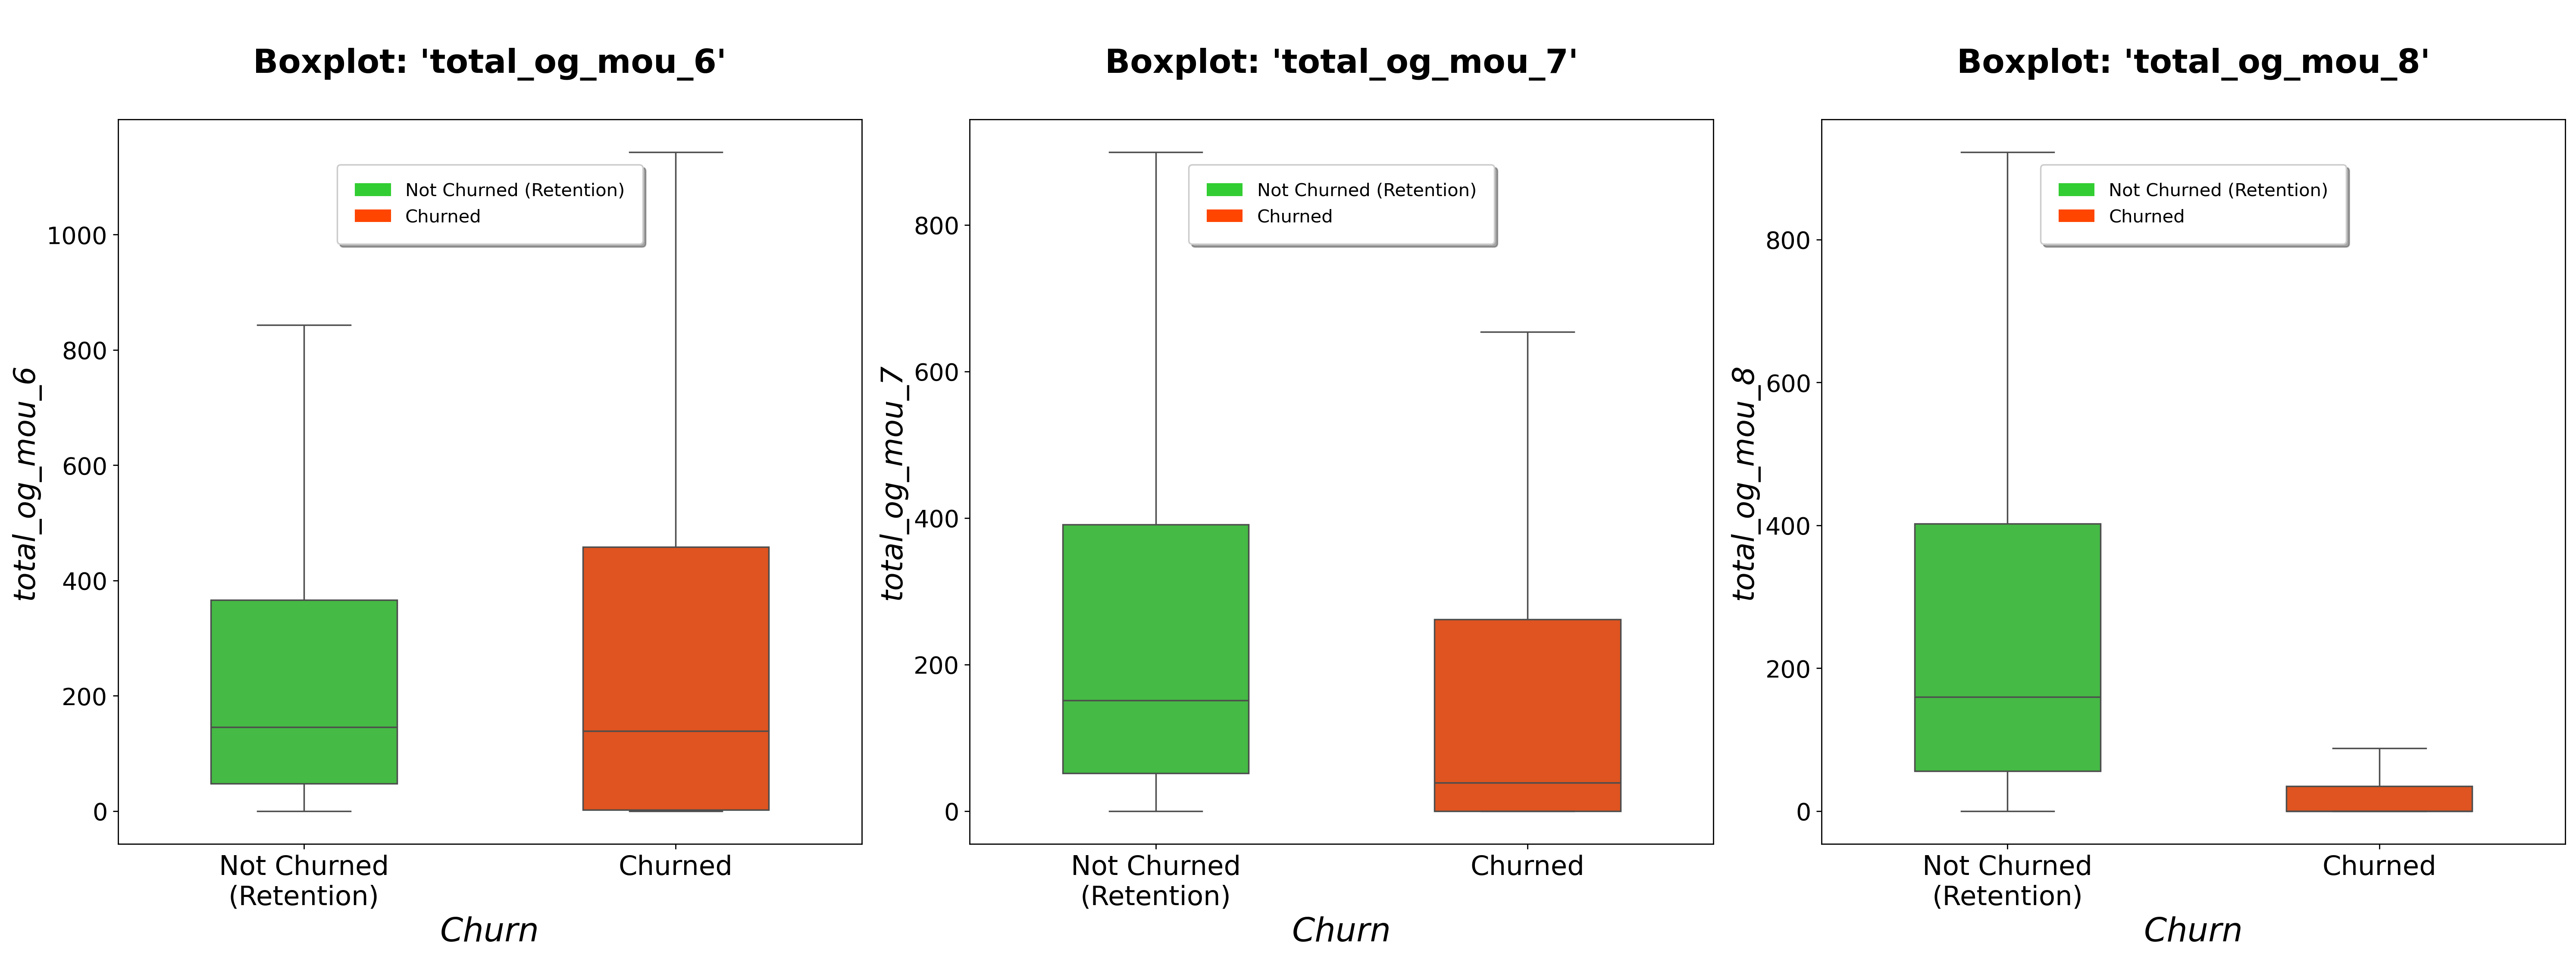

In [24]:
# Total Outgoing
plot_boxplots_6_7_8("total_og_mou")

#### General Observations

Outliers: There are some outliers present in the data, especially for the churned customers in total_og_mou_6. These outliers suggest that some churned customers have significantly higher outgoing minutes compared to the majority.
Churn vs. Non-Churn

Median: The median outgoing minutes for churned customers are generally lower than those for non-churned customers across all three months. This suggests that customers who churn tend to have lower outgoing minutes.
Distribution: The distribution of outgoing minutes for churned customers is more spread out (higher variability) compared to non-churned customers, particularly in total_og_mou_6. This indicates that churned customers exhibit a wider range of outgoing minutes.
Month-to-Month Comparison

Total_og_mou_6: The median outgoing minutes for both churned and non-churned customers are highest in this month.
Total_og_mou_7: There's a slight decrease in the median outgoing minutes for both groups compared to total_og_mou_6.
Total_og_mou_8: The median outgoing minutes continue to decrease for both groups compared to the previous months.
Possible Interpretations

Lower Usage as a Churn Indicator: The lower outgoing minutes for churned customers might suggest that decreasing usage is a potential indicator of churn.
Usage Patterns and Churn: The spread in outgoing minutes for churned customers might indicate that there are different usage patterns among customers who churn. Some might have very low usage, while others might have high usage but still churn due to other factors.

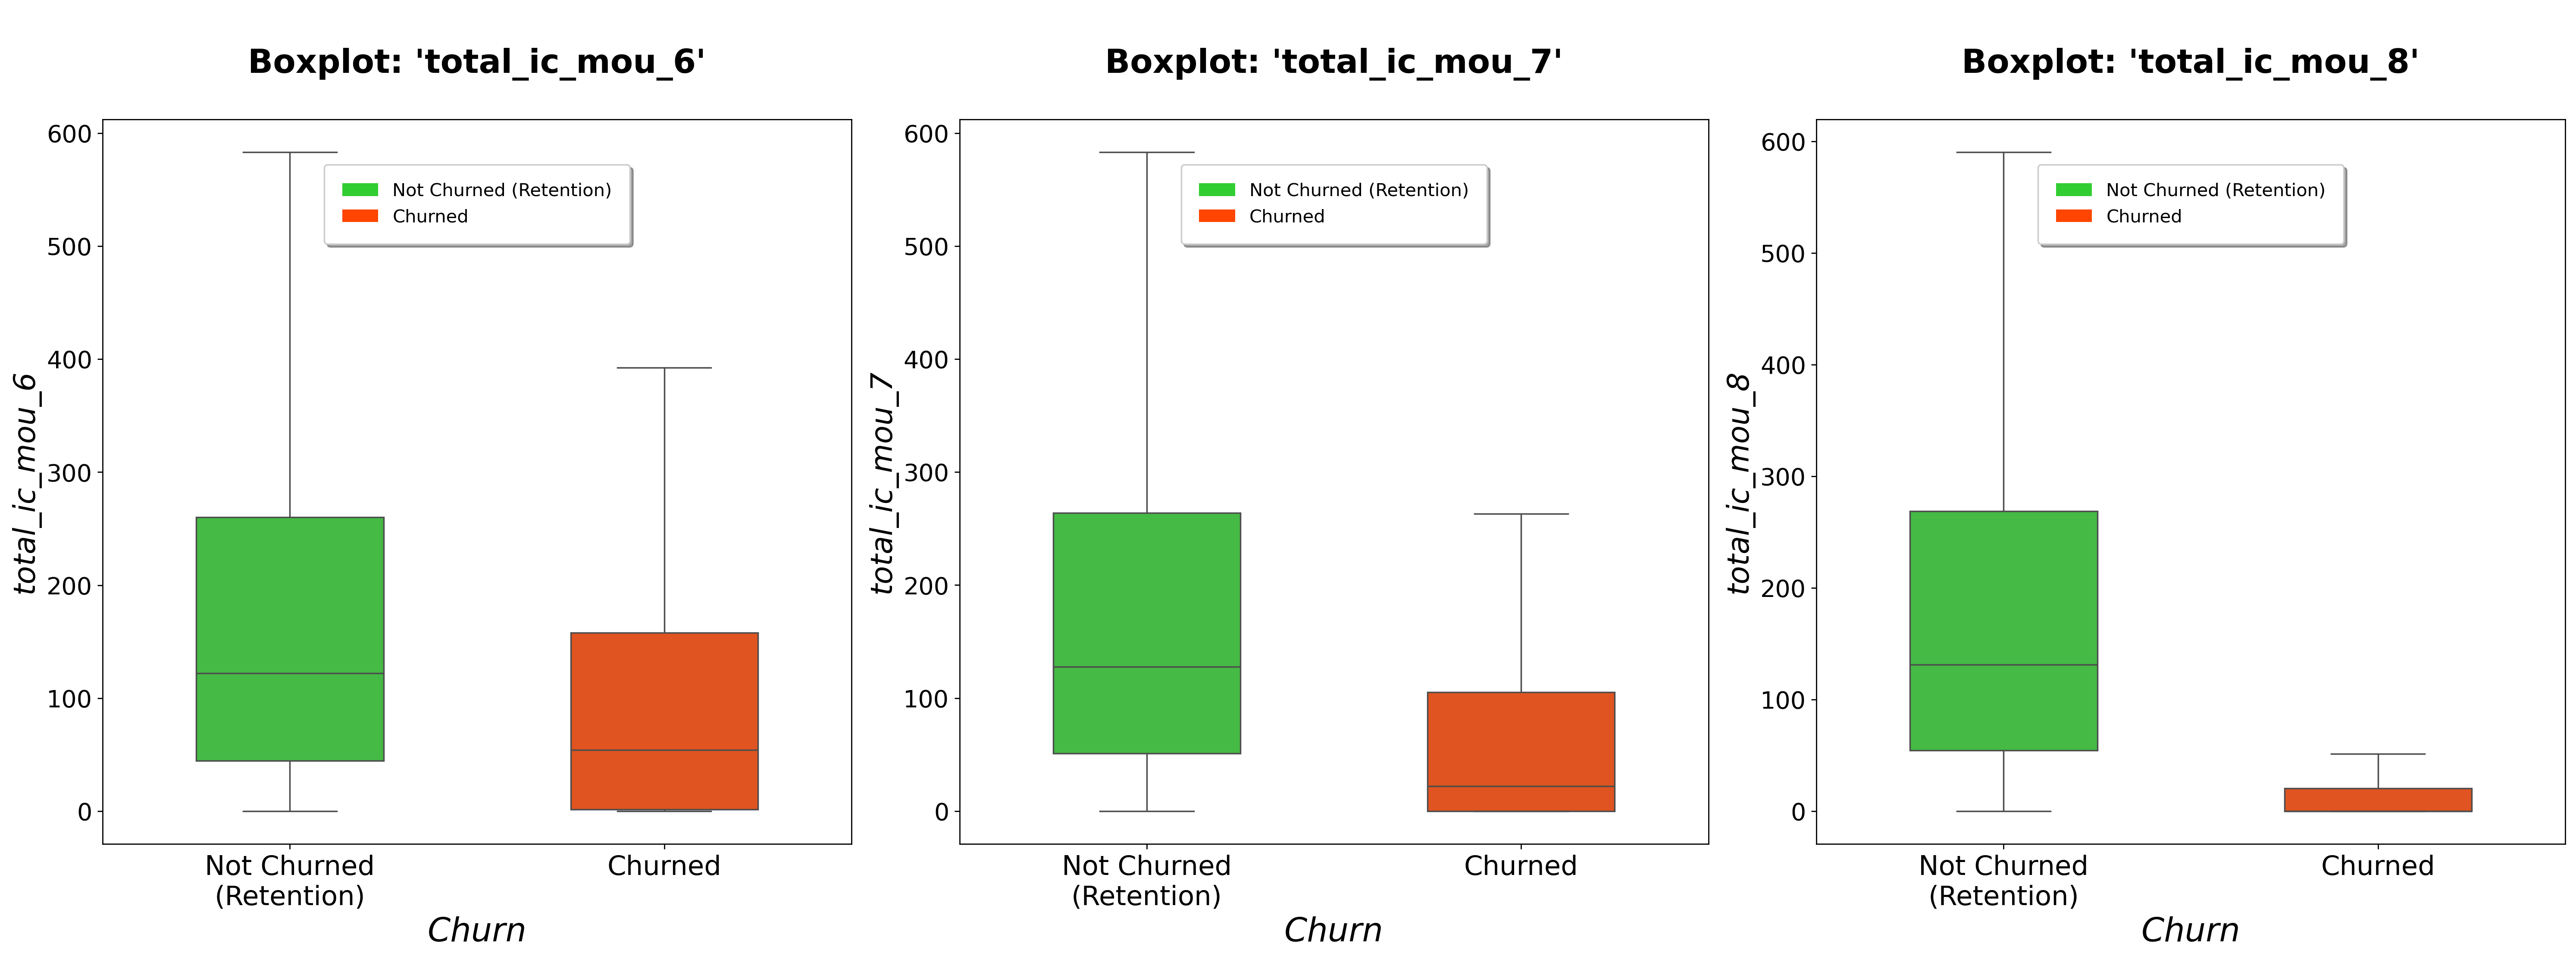

In [26]:
# Total Incoming
plot_boxplots_6_7_8("total_ic_mou")

#### General Observations

Outliers: There are some outliers present in the data, especially for the churned customers in total_ic_mou_6. These outliers suggest that some churned customers have significantly higher incoming minutes compared to the majority.
Churn vs. Non-Churn

Median: The median incoming minutes for churned customers are generally lower than those for non-churned customers across all three months. This suggests that customers who churn tend to have lower incoming minutes.
Distribution: The distribution of incoming minutes for churned customers is more spread out (higher variability) compared to non-churned customers, particularly in total_ic_mou_6. This indicates that churned customers exhibit a wider range of incoming minutes.
Month-to-Month Comparison

Total_ic_mou_6: The median incoming minutes for both churned and non-churned customers are highest in this month.
Total_ic_mou_7: There's a slight decrease in the median incoming minutes for both groups compared to total_ic_mou_6.
Total_ic_mou_8: The median incoming minutes continue to decrease for both groups compared to the previous months.
Possible Interpretations

Lower Usage as a Churn Indicator: The lower incoming minutes for churned customers might suggest that decreasing usage is a potential indicator of churn.
Usage Patterns and Churn: The spread in incoming minutes for churned customers might indicate that there are different usage patterns among customers who churn. Some might have very low usage, while others might have high usage but still churn due to other factors.



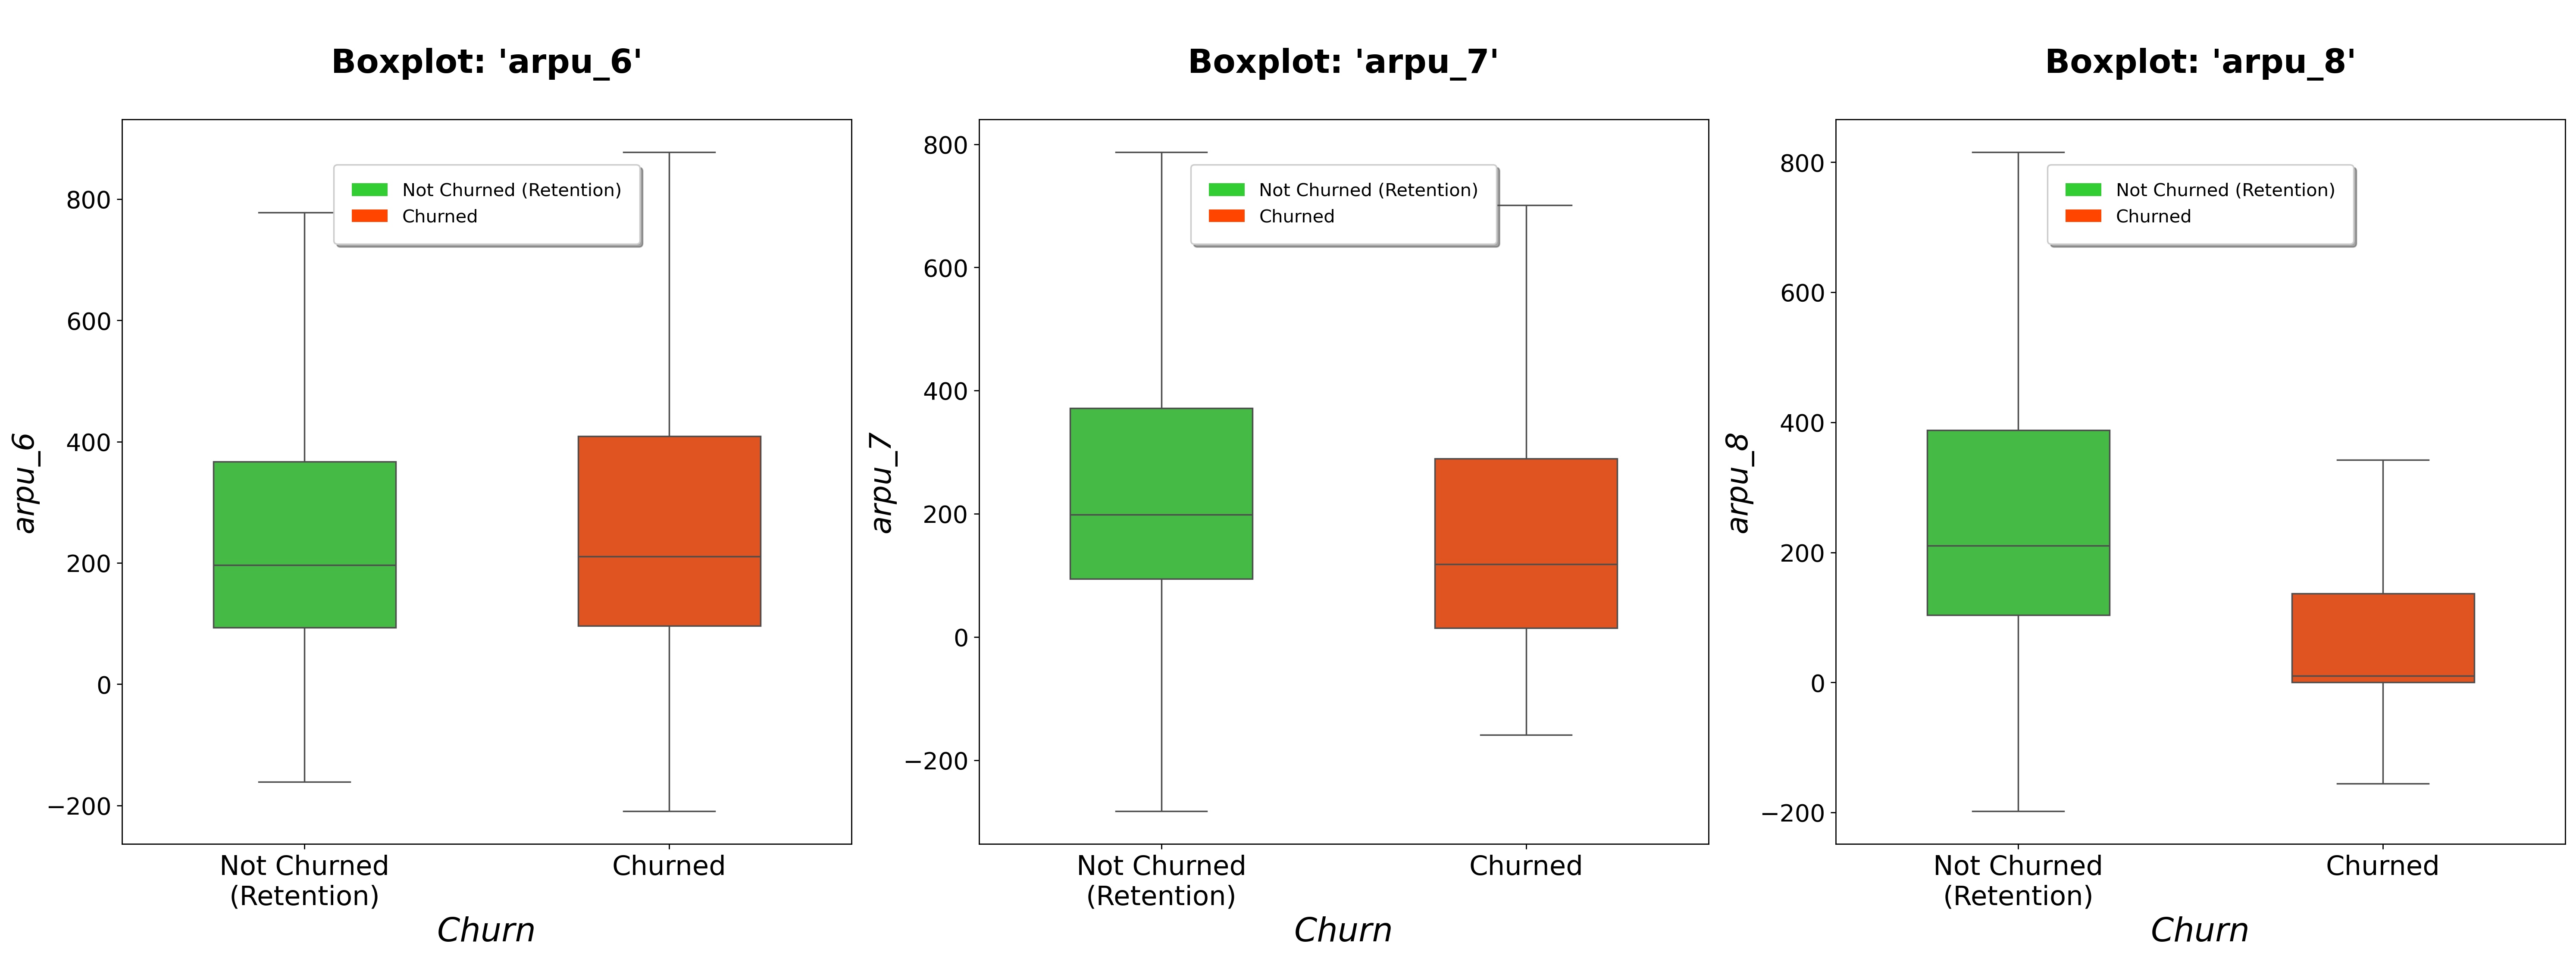

In [28]:
# Average Revenue Per User
plot_boxplots_6_7_8("arpu")

### General Observations:

Outliers: There are some outliers present in the data, especially for churned customers in arpu_6. This indicates that a few churned customers had significantly higher ARPU compared to the majority.
Churn vs. Non-Churn

Median: The median ARPU for churned customers is generally lower than that for non-churned customers across all three months. This suggests that customers who churn tend to have lower revenue generation.
Distribution: The distribution of ARPU for churned customers is more spread out (higher variability) compared to non-churned customers, particularly in arpu_6. This indicates that churned customers exhibit a wider range of ARPU values.
Month-to-Month Comparison

arpu_6: The median ARPU for both churned and non-churned customers is highest in this month.
arpu_7: There's a slight decrease in the median ARPU for both groups compared to arpu_6.
arpu_8: The median ARPU continues to decrease for both groups compared to the previous months.
Possible Interpretations

Revenue Decline as Churn Indicator: The lower ARPU for churned customers might suggest that decreasing revenue generation is a potential indicator of churn.
Revenue Patterns and Churn: The spread in ARPU for churned customers might indicate that there are different revenue patterns among customers who churn. Some might have very low revenue, while others might have higher revenue but still churn due to other factors.



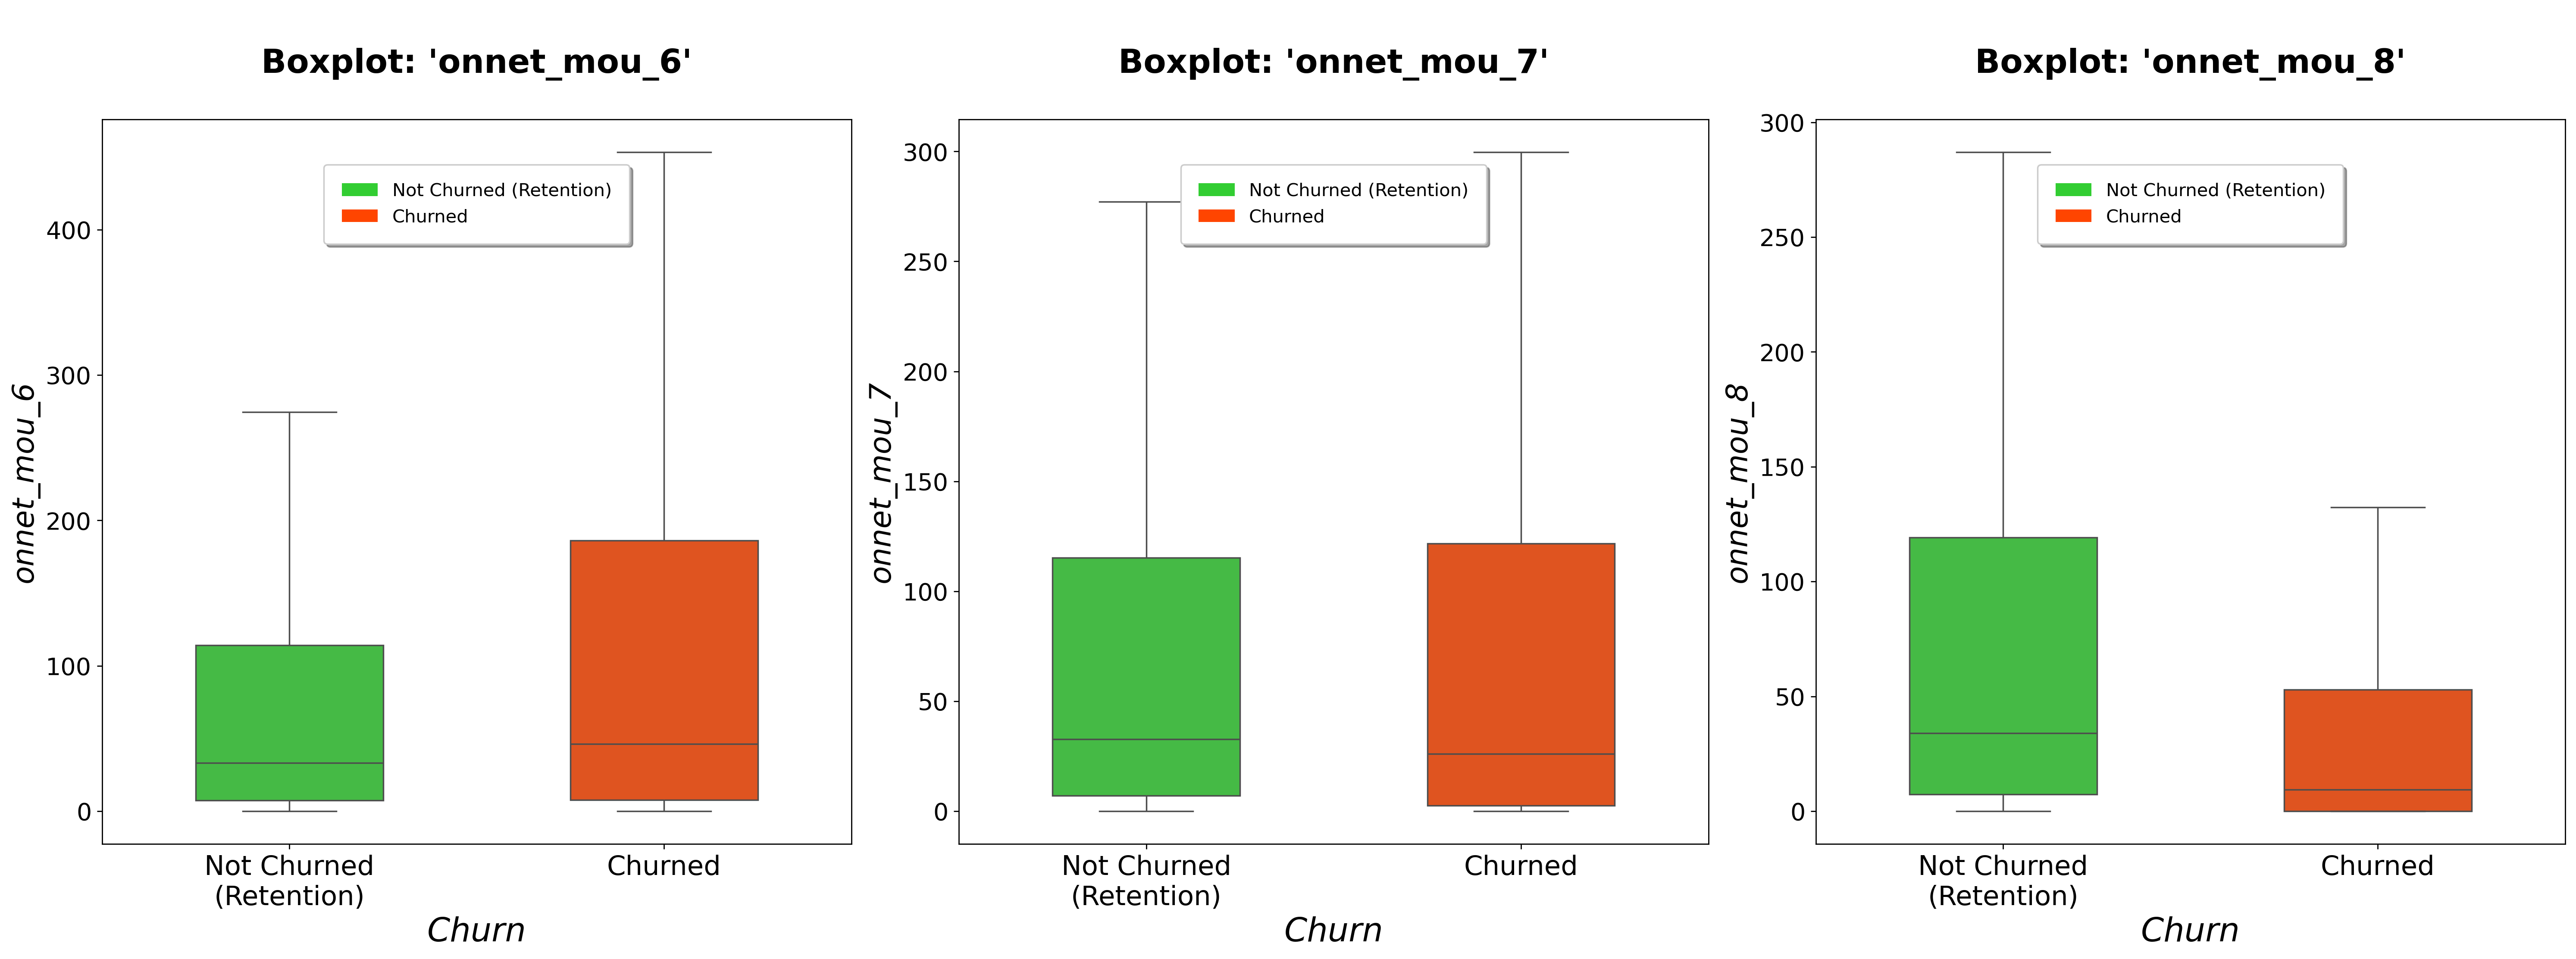

In [30]:
# Minutes of Usage on-network
plot_boxplots_6_7_8("onnet_mou")

#### General Observations

Outliers: There are some outliers present in the data, especially for the churned customers in onnet_mou_6. These outliers suggest that some churned customers have significantly higher on-net minutes compared to the majority.
Churn vs. Non-Churn

Median: The median on-net minutes for churned customers are generally lower than those for non-churned customers across all three months. This suggests that customers who churn tend to have lower on-net minutes.
Distribution: The distribution of on-net minutes for churned customers is more spread out (higher variability) compared to non-churned customers, particularly in onnet_mou_6. This indicates that churned customers exhibit a wider range of on-net minutes.
Month-to-Month Comparison

onnet_mou_6: The median on-net minutes for both churned and non-churned customers are highest in this month.
onnet_mou_7: There's a slight decrease in the median on-net minutes for both groups compared to onnet_mou_6.
onnet_mou_8: The median on-net minutes continue to decrease for both groups compared to the previous months.
Possible Interpretations

Lower Usage as a Churn Indicator: The lower on-net minutes for churned customers might suggest that decreasing usage is a potential indicator of churn.
Usage Patterns and Churn: The spread in on-net minutes for churned customers might indicate that there are different usage patterns among customers who churn. Some might have very low usage, while others might have high usage but still churn due to other factors.



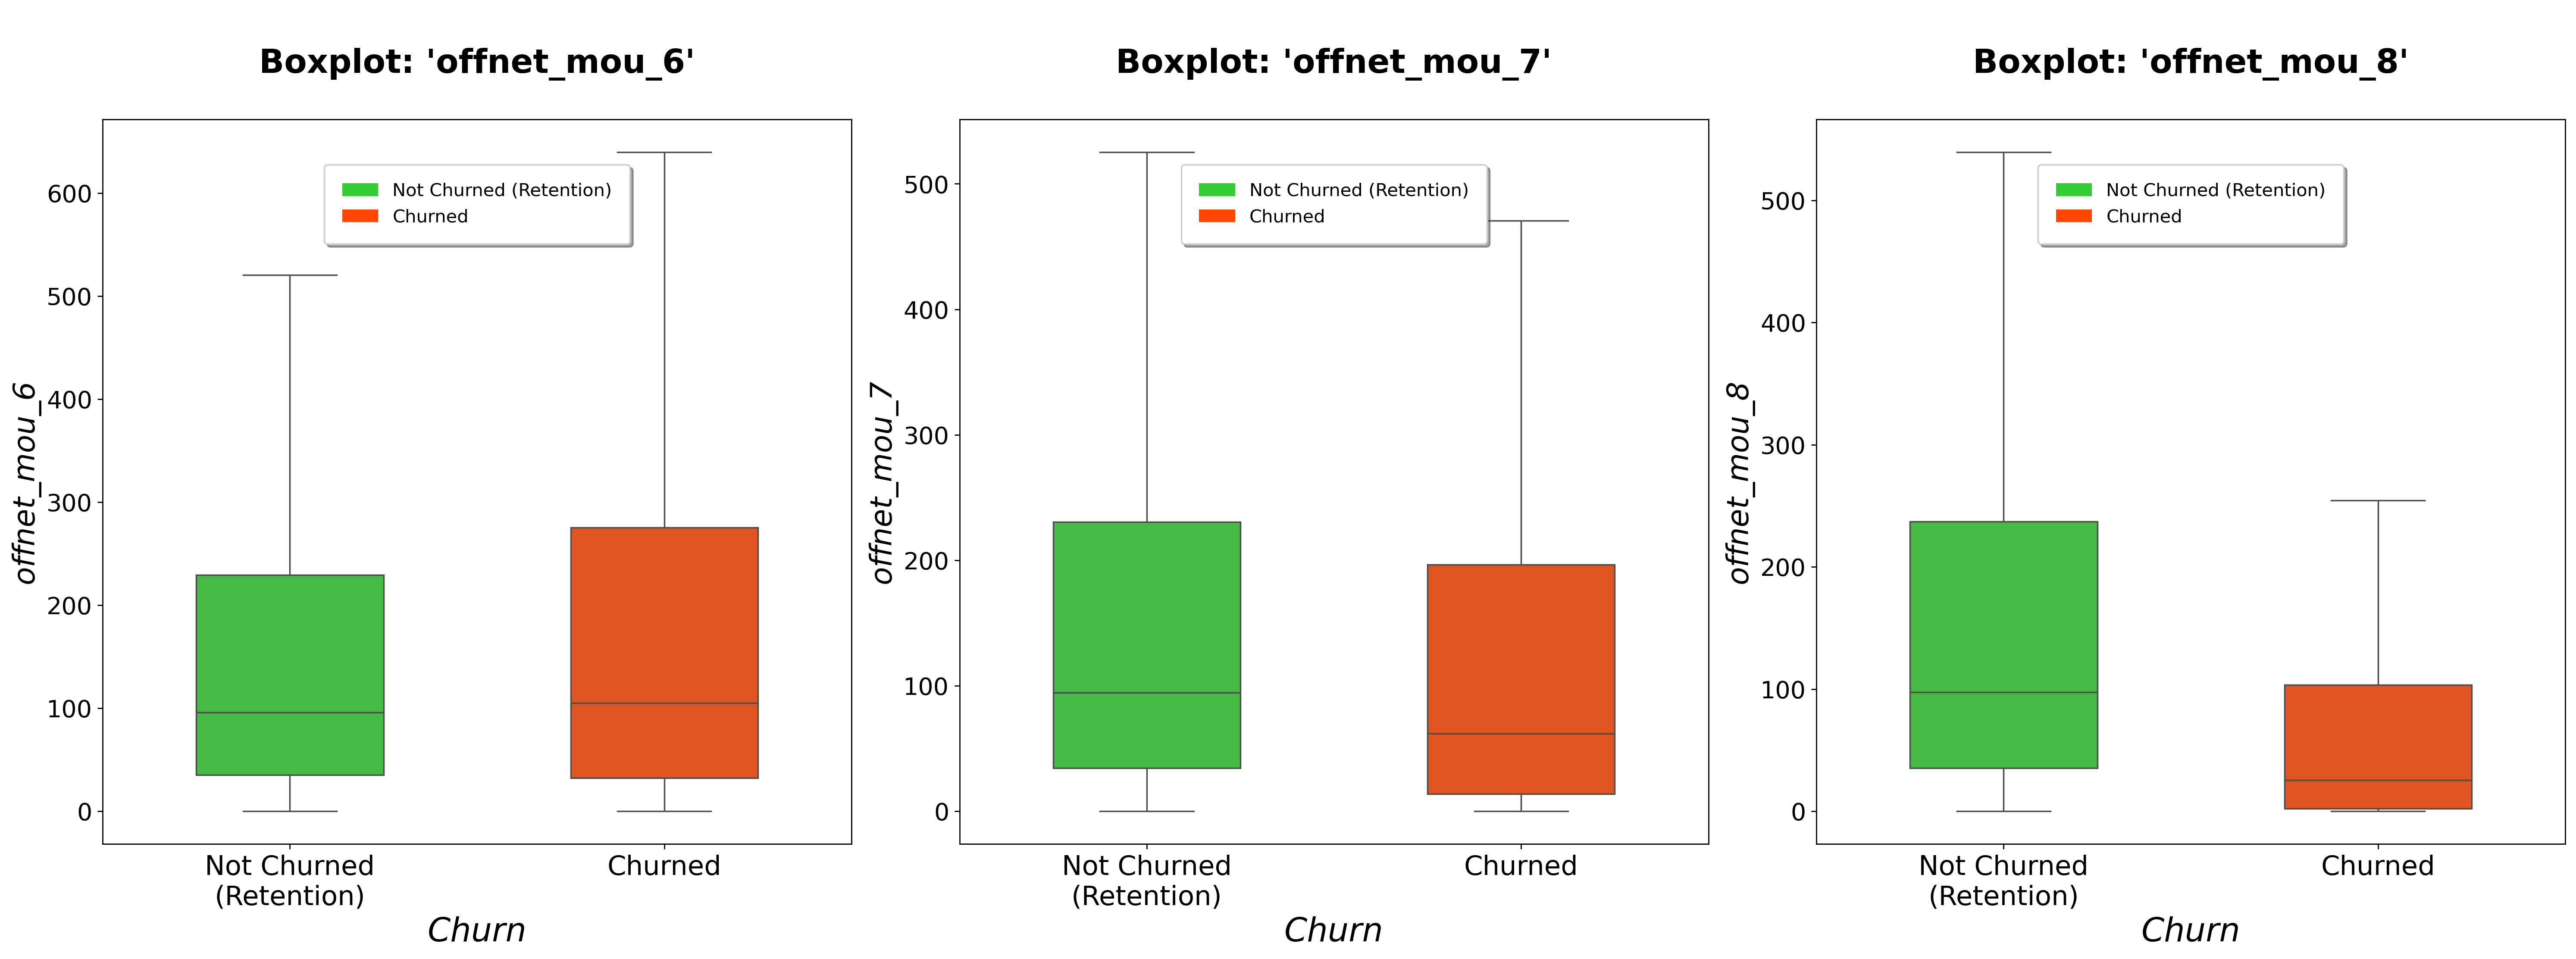

In [32]:
## Minutes of Usage off-network
plot_boxplots_6_7_8("offnet_mou")

#### General Observations

Outliers: There are some outliers present in the data, especially for the churned customers in offnet_mou_6. These outliers suggest that some churned customers have significantly higher off-net minutes compared to the majority.
Churn vs. Non-Churn

Median: The median off-net minutes for churned customers are generally lower than those for non-churned customers across all three months. This suggests that customers who churn tend to have lower off-net minutes.
Distribution: The distribution of off-net minutes for churned customers is more spread out (higher variability) compared to non-churned customers, particularly in offnet_mou_6. This indicates that churned customers exhibit a wider range of off-net minutes.
Month-to-Month Comparison

offnet_mou_6: The median off-net minutes for both churned and non-churned customers are highest in this month.
offnet_mou_7: There's a slight decrease in the median off-net minutes for both groups compared to offnet_mou_6.
offnet_mou_8: The median off-net minutes continue to decrease for both groups compared to the previous months.
Possible Interpretations

Lower Usage as a Churn Indicator: The lower off-net minutes for churned customers might suggest that decreasing usage is a potential indicator of churn.
Usage Patterns and Churn: The spread in off-net minutes for churned customers might indicate that there are different usage patterns among customers who churn. Some might have very low usage, while others might have high usage but still churn due to other factors.

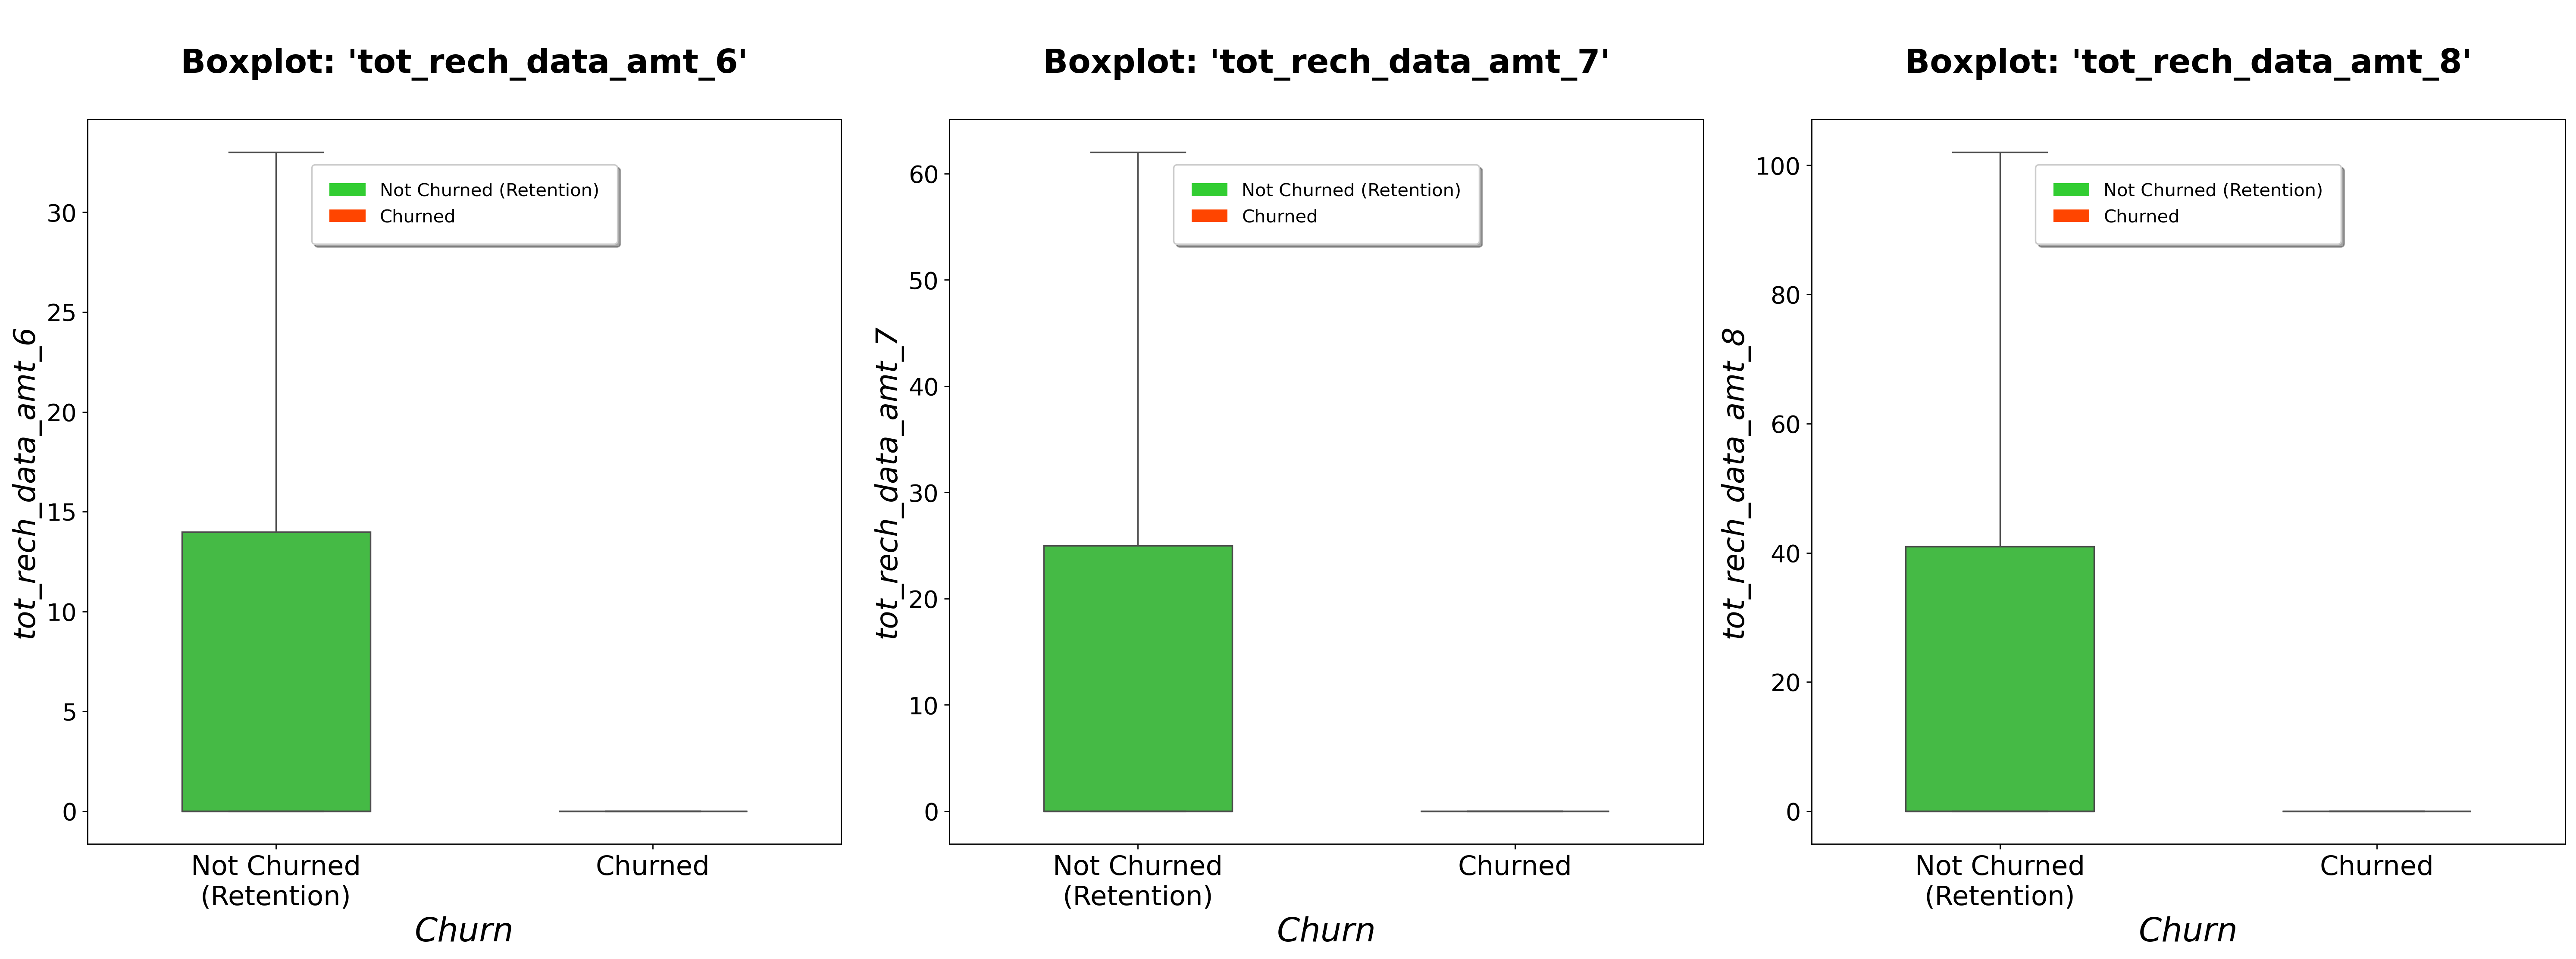

In [34]:
plot_boxplots_6_7_8("tot_rech_data_amt")

#### General Observations

Outliers: There are no outliers present in the data for any of the months.
Churn vs. Non-Churn

Median: The median total data recharge amount for churned customers is generally lower than that for non-churned customers across all three months. This suggests that customers who churn tend to have lower data recharge amounts.
Distribution: The distribution of total data recharge amounts for churned customers is more spread out (higher variability) compared to non-churned customers, particularly in tot_rech_data_amt_6. This indicates that churned customers exhibit a wider range of data recharge amounts.
Month-to-Month Comparison

tot_rech_data_amt_6: The median total data recharge amount for both churned and non-churned customers is highest in this month.
tot_rech_data_amt_7: There's a slight decrease in the median total data recharge amount for both groups compared to tot_rech_data_amt_6.
tot_rech_data_amt_8: The median total data recharge amount continues to decrease for both groups compared to the previous months.



In [36]:
usage_2g_3g_vars = list(data.columns[data.columns.str.contains('2g|3g',regex=True)])
null_prcnt_df(data[usage_2g_3g_vars])

,Null_Percentage
count_rech_2g_6,74.902499
arpu_3g_6,74.902499
count_rech_3g_6,74.902499
arpu_2g_6,74.902499
count_rech_2g_7,74.478207
arpu_3g_7,74.478207
arpu_2g_7,74.478207
count_rech_3g_7,74.478207
count_rech_3g_8,73.689624
arpu_3g_8,73.689624


In [37]:
##Dropping 'arpu_2g', 'arpu_3g', 'count_rech_2g' and 'count_rech_3g' based features (revenue_based)
drop_vars = list(data.columns[data.columns.str.contains('arpu_2g|arpu_3g|count_rech_2g_|count_rech_3g')])
data.drop(drop_vars, axis=1, inplace=True)

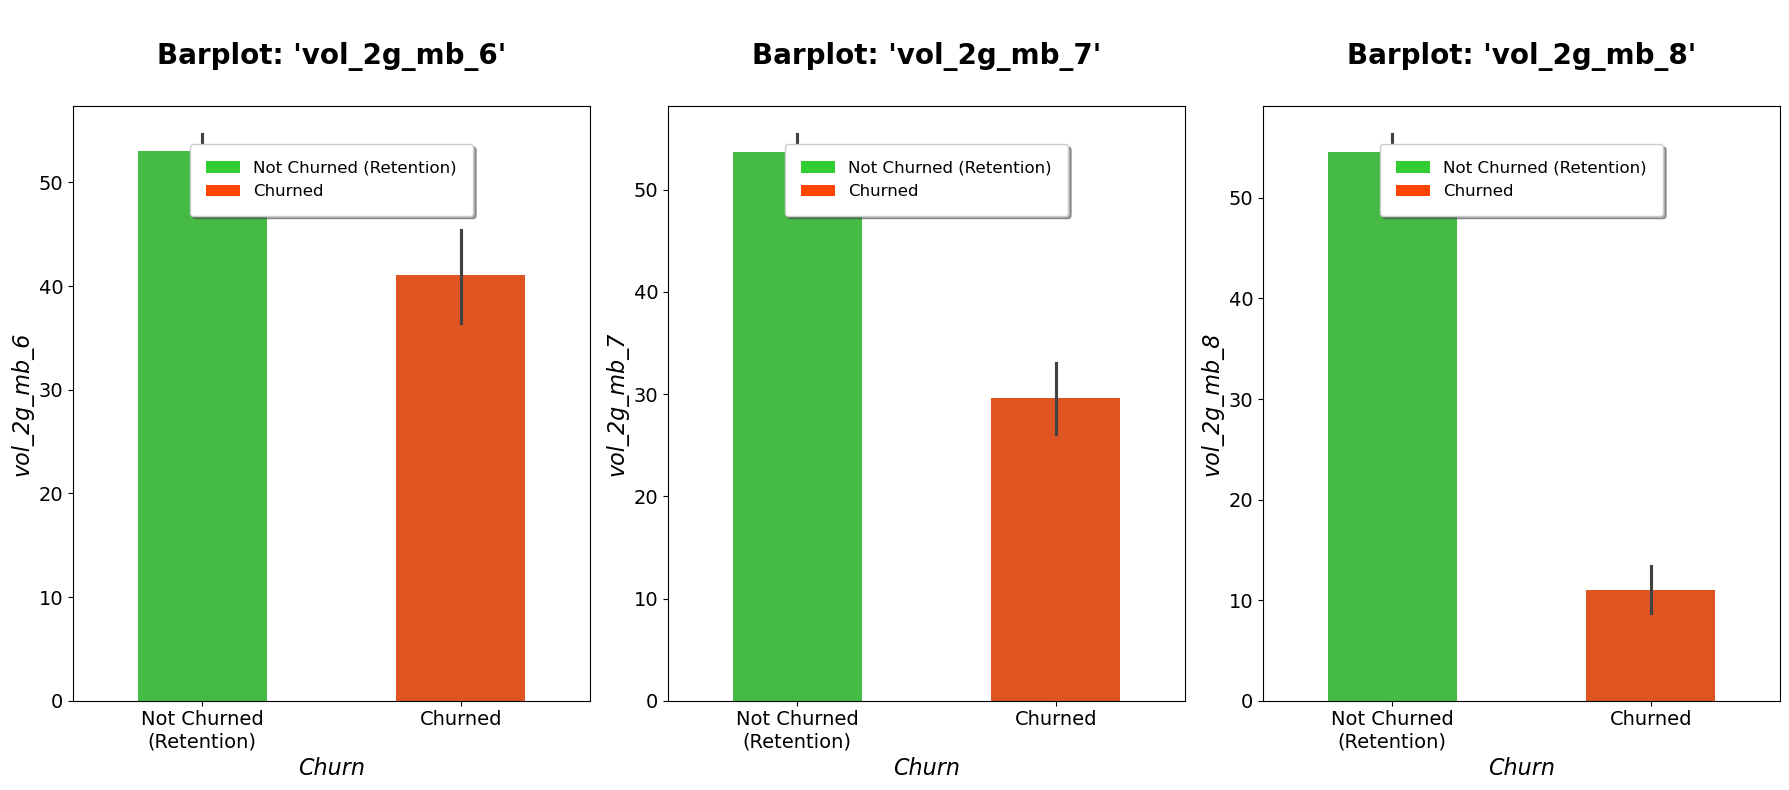

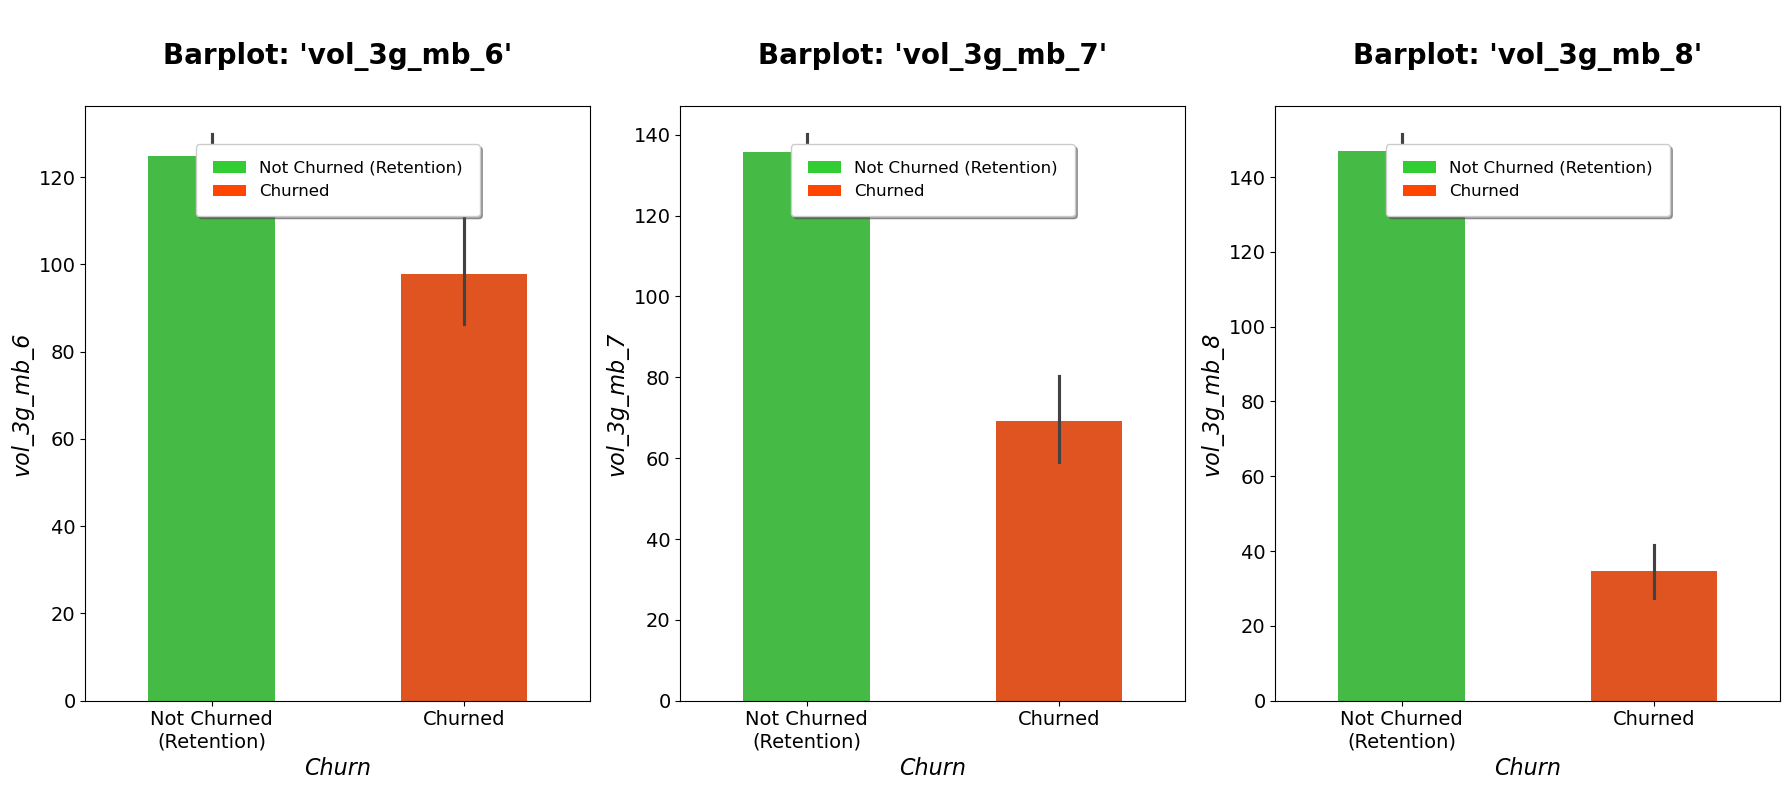

In [38]:
plot_barplots_6_7_8("vol_2g_mb")
plot_barplots_6_7_8("vol_3g_mb")

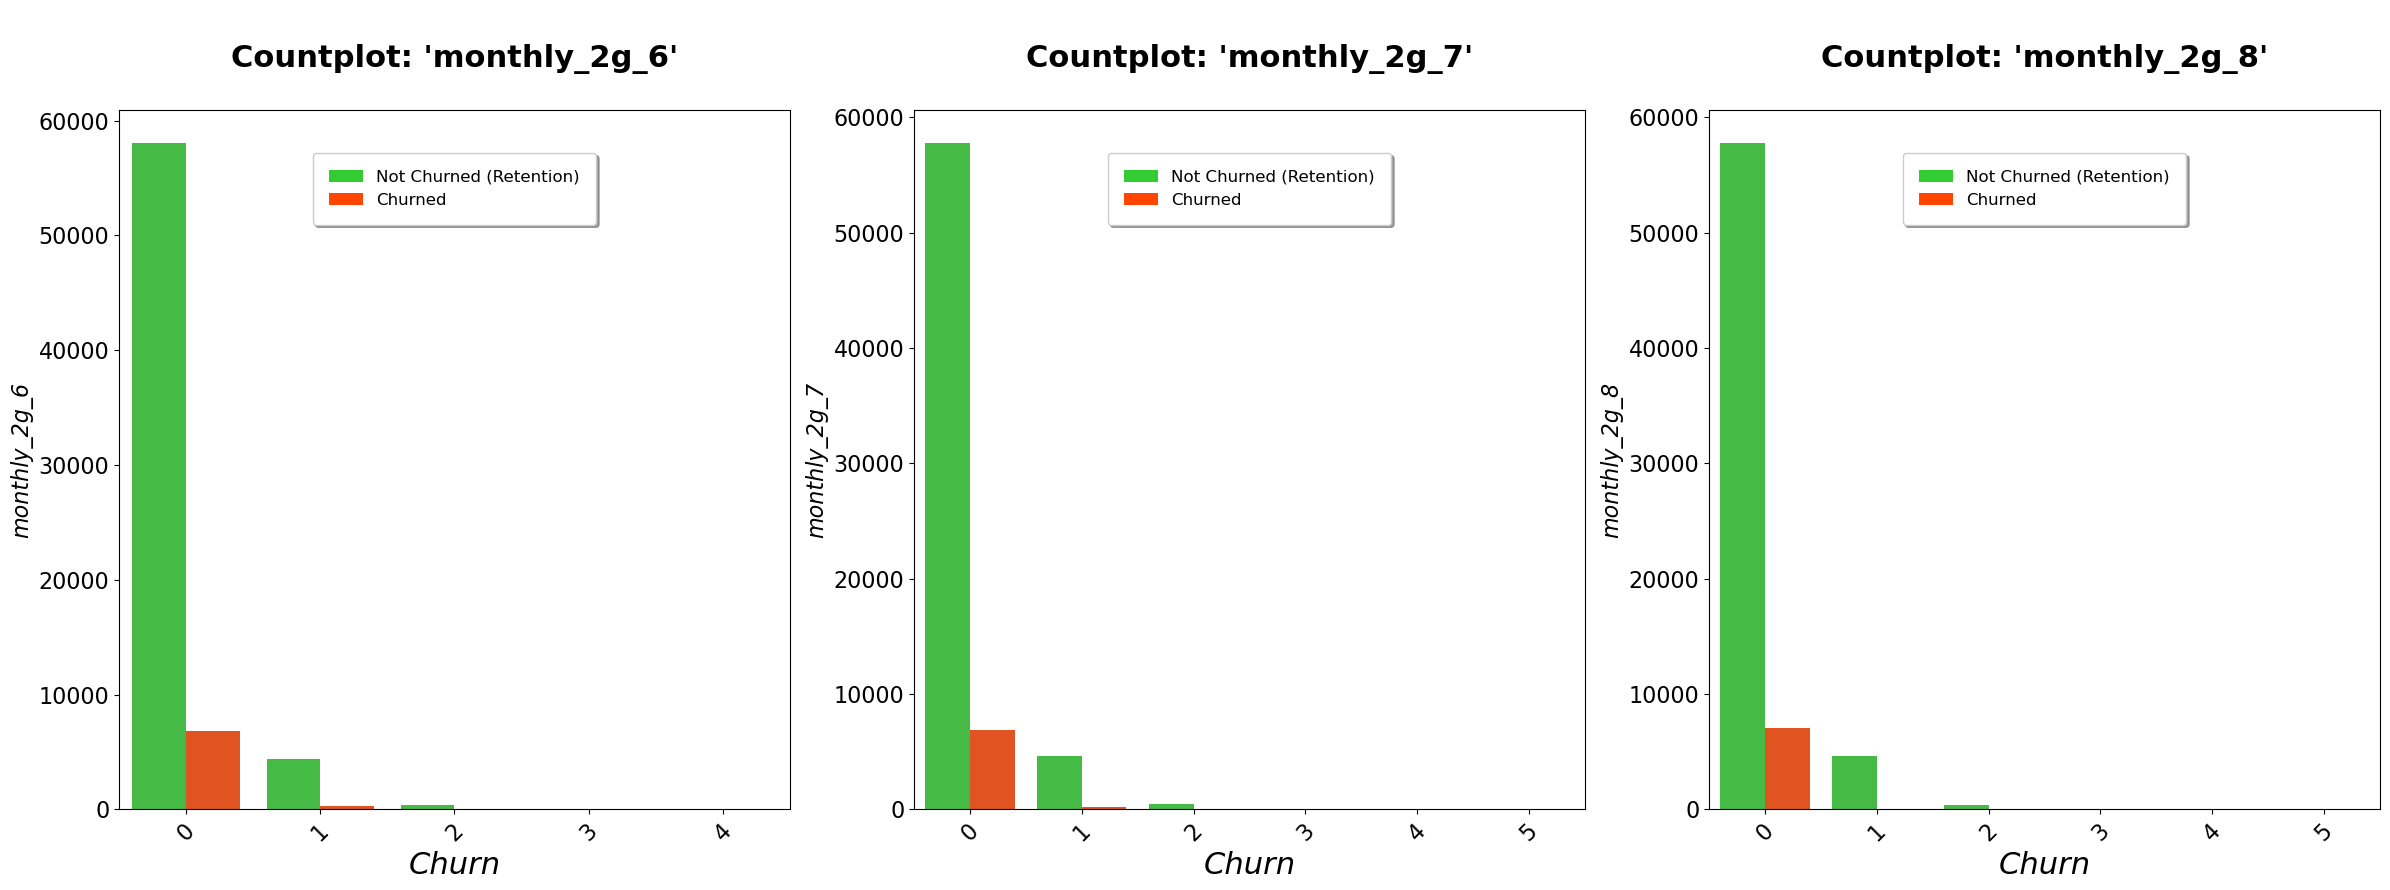

In [39]:
plot_countplots_6_7_8("monthly_2g")

#### General Observations

Distribution: The distribution of monthly_2g usage is heavily skewed towards the lower end for both churned and non-churned customers in all three months. This suggests that a significant portion of customers have low or no 2G usage.
Churn vs. Non-Churn

Usage: The majority of customers in all three months, regardless of churn status, fall into the lowest usage categories (0-2).
Churn Proportion: The proportion of churned customers within each usage category is generally lower than the proportion of non-churned customers. This suggests that customers with higher monthly_2g usage might be less likely to churn.
Month-to-Month Comparison

Usage Patterns: The overall usage patterns seem to be relatively consistent across the three months.
Churn Proportion: The proportion of churned customers within each usage category appears to remain fairly stable across the months.
Possible Interpretations

Usage and Churn: While the relationship might not be straightforward, higher monthly_2g usage could be associated with a lower churn risk.

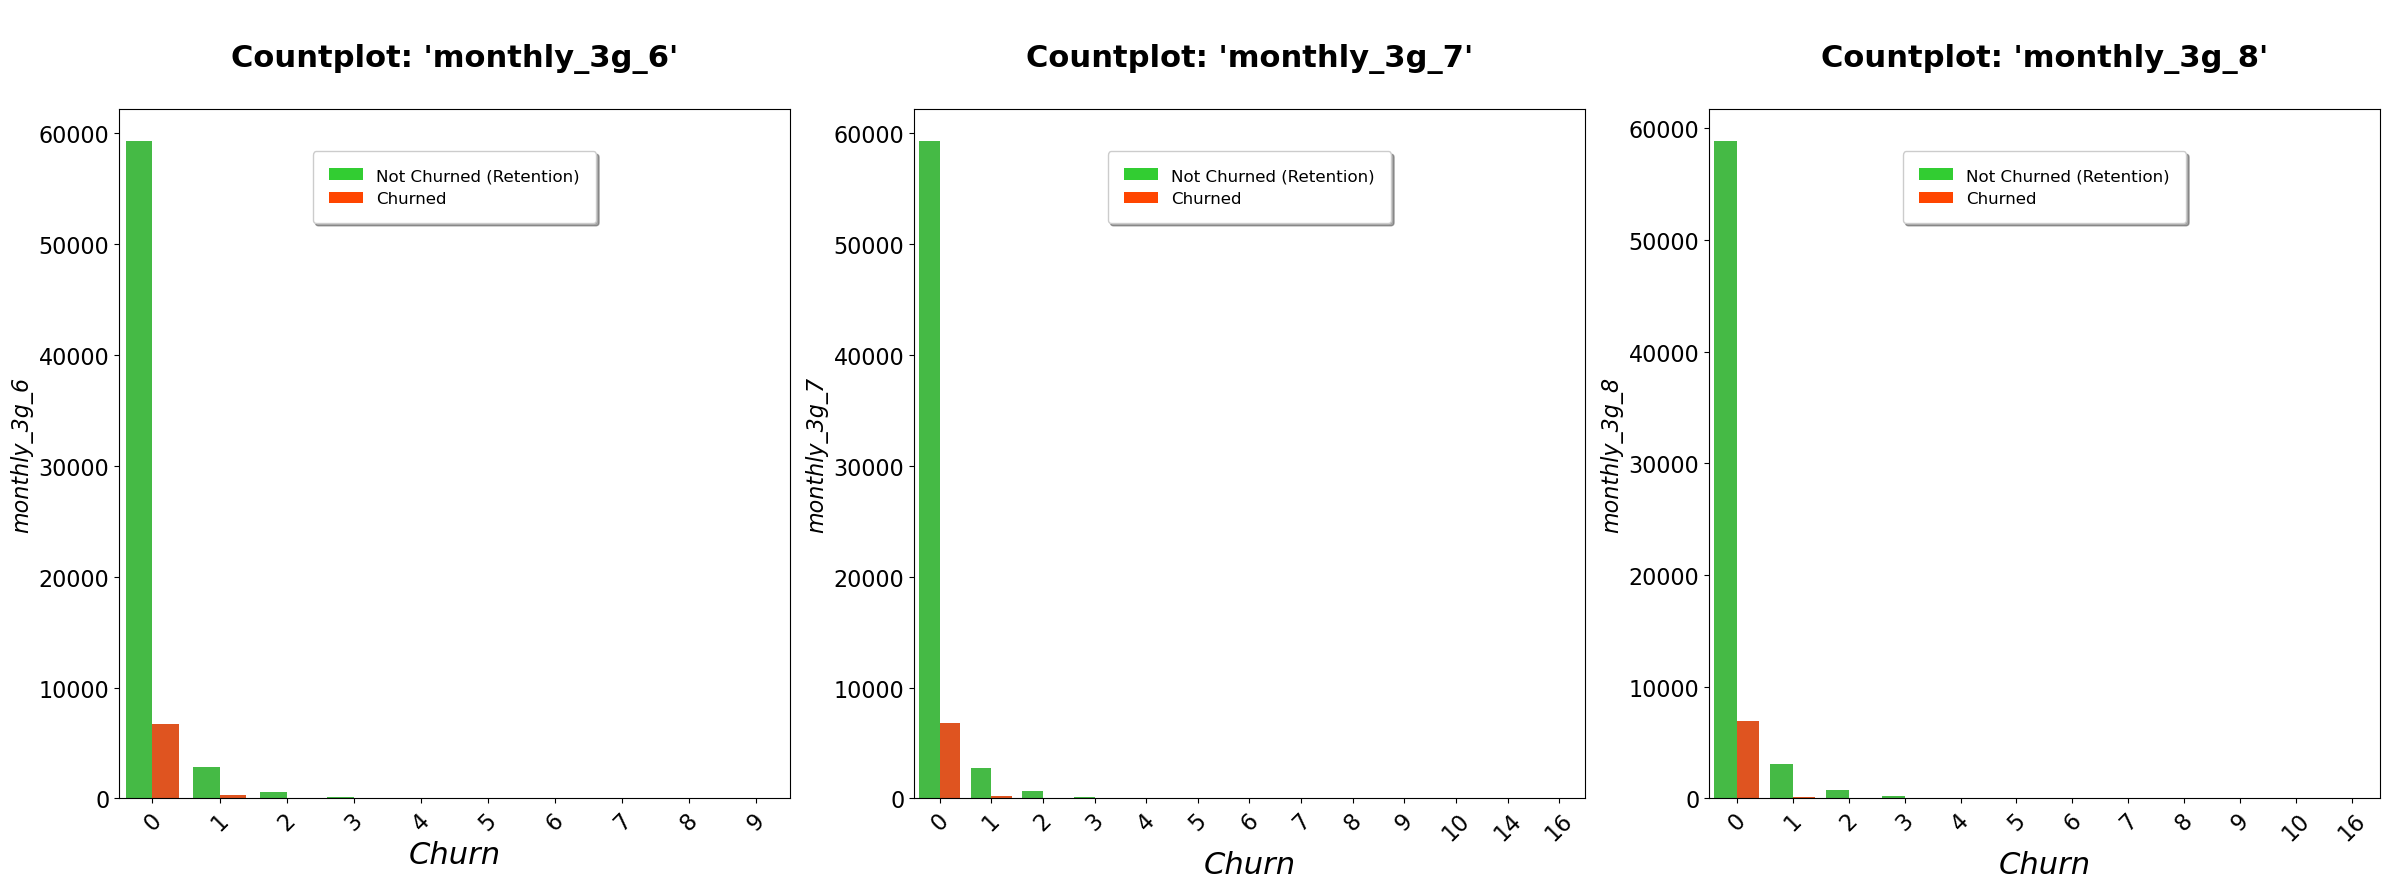

In [41]:
plot_countplots_6_7_8("monthly_3g")

#### General Observations

Distribution: The distribution of monthly_3g usage is heavily skewed towards the lower end for both churned and non-churned customers in all three months. This suggests that a significant portion of customers have low or no 3G usage.
Churn vs. Non-Churn

Usage: The majority of customers in all three months, regardless of churn status, fall into the lowest usage categories (0-2).
Churn Proportion: The proportion of churned customers within each usage category is generally lower than the proportion of non-churned customers. This suggests that customers with higher monthly_3g usage might be less likely to churn.
Month-to-Month Comparison

Usage Patterns: The overall usage patterns seem to be relatively consistent across the three months.
Churn Proportion: The proportion of churned customers within each usage category appears to remain fairly stable across the months.
Possible Interpretations

Usage and Churn: While the relationship might not be straightforward, higher monthly_3g usage could be associated with a lower churn risk.

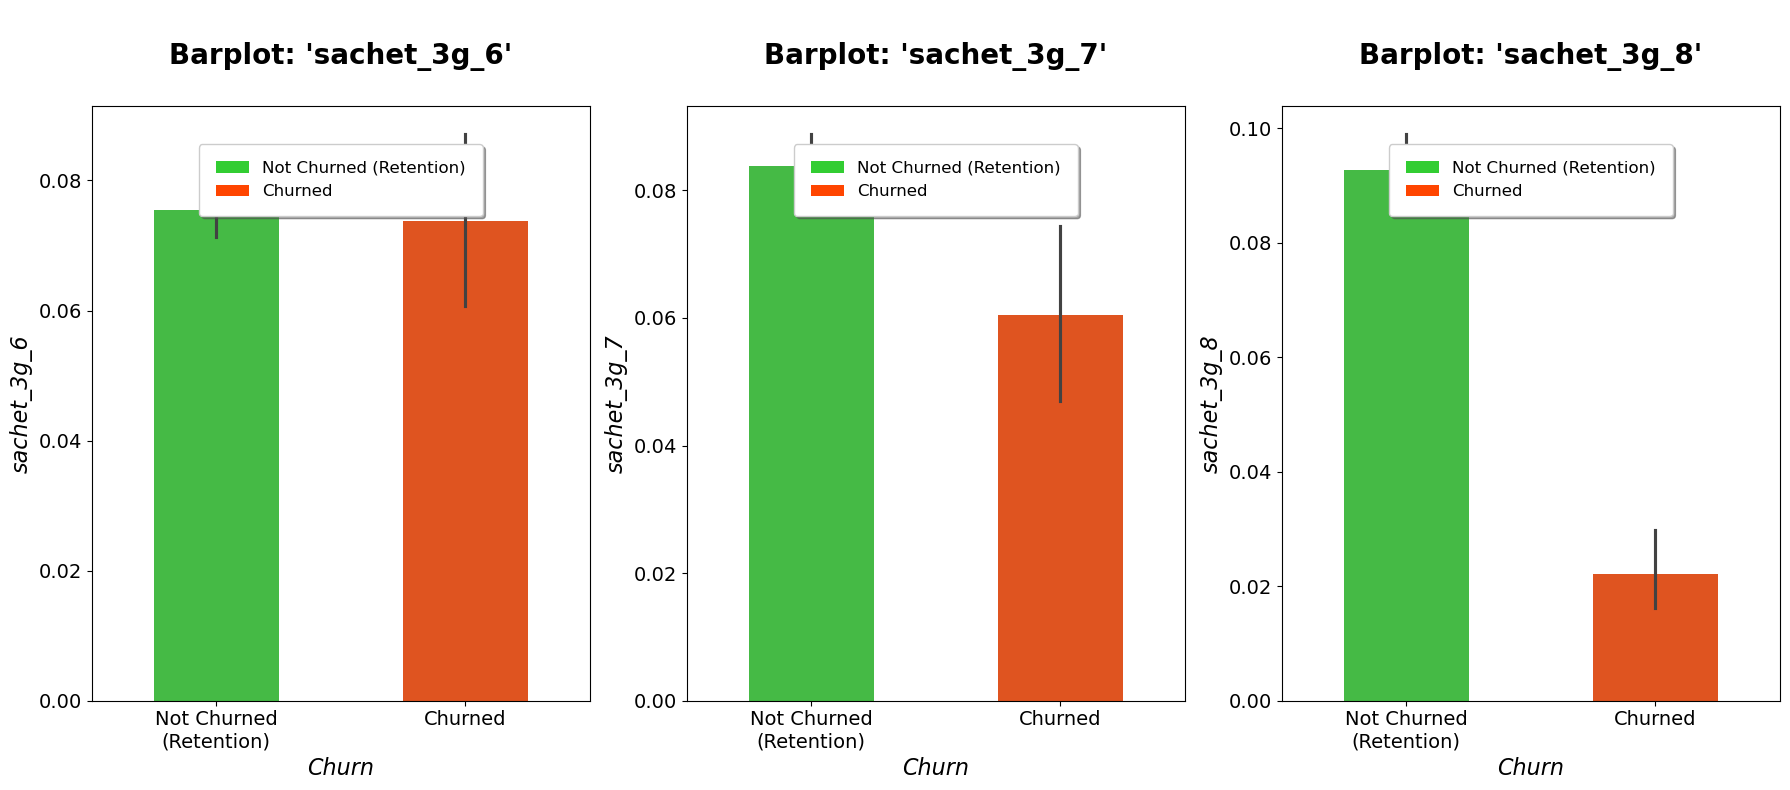

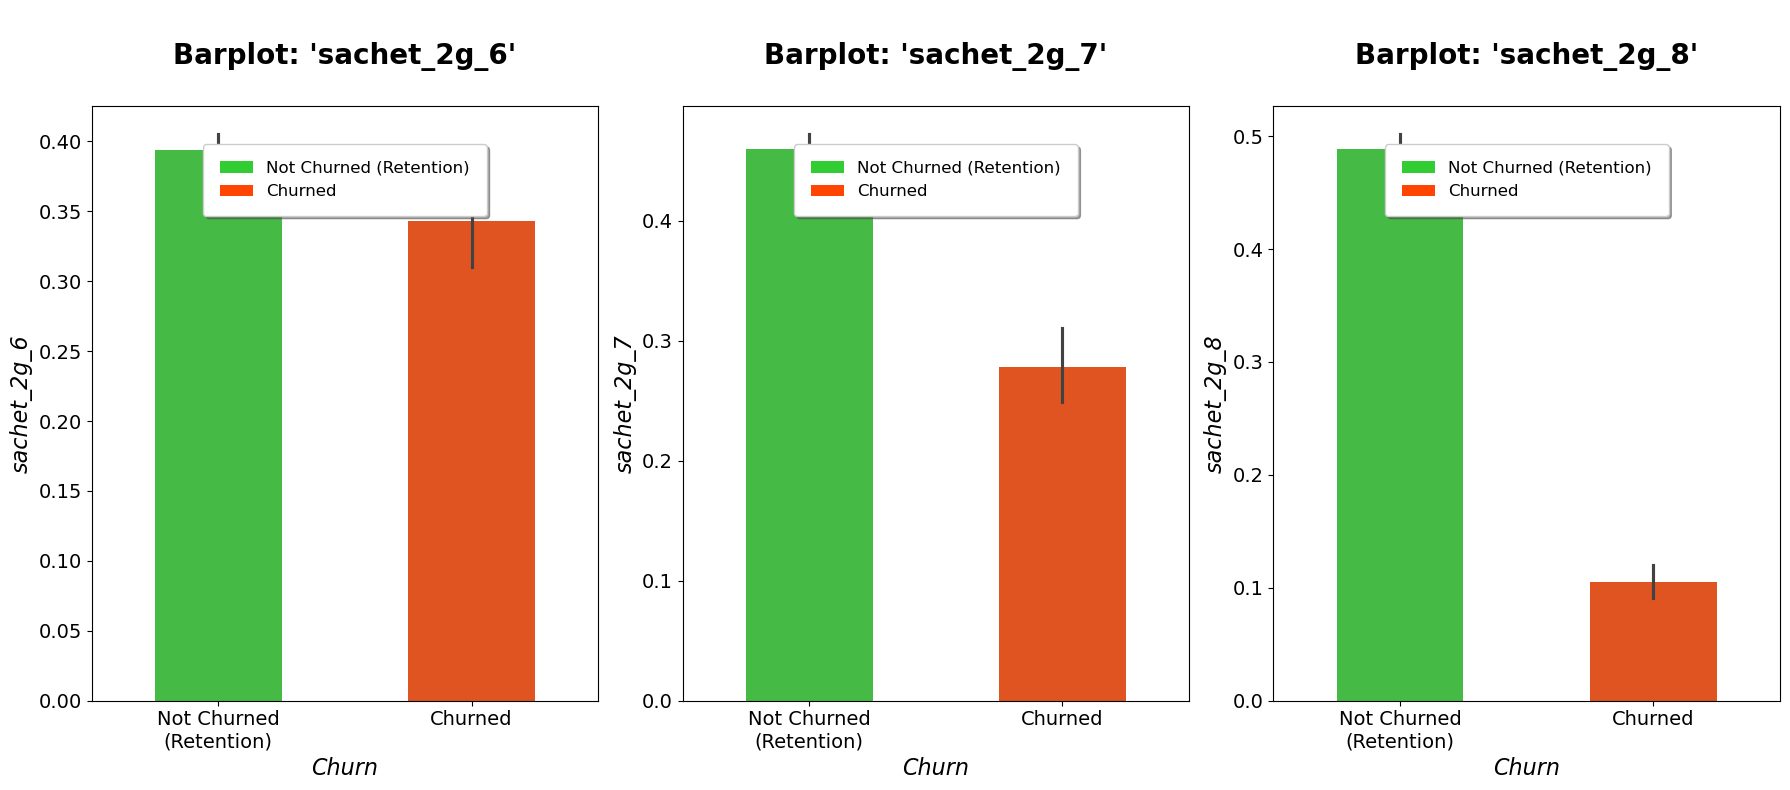

In [43]:
plot_barplots_6_7_8("sachet_3g")

plot_barplots_6_7_8("sachet_2g")

Tenure (Age on network) Analysis

The AON variable was used to create tenure buckets. [AON: Age on network (in number of days)]
It is observerd that larger the tenure, lesser was the churn - as customers who are newly acquired by the network churned more often in comparison to the old customers.

In [45]:
##Creating  a new column tenure_year to store the number of years the customer has been on network T
data['tenure_year'] = round(data['aon']/365, 1)

print(data.tenure_year.value_counts())
print("Min:",data.tenure_year.min())
print("Max:",data.tenure_year.max())

tenure_year
1.3     3334
0.6     2531
0.8     2366
1.0     2316
0.9     2293
        ... 
11.7       2
11.9       1
11.6       1
10.7       1
11.0       1
Name: count, Length: 107, dtype: int64
Min: 0.5
Max: 11.9


In [46]:
##Creating bins
my_bins = [0,1,2,3,5,12]
my_labels_aon= ['0_1_year','1_2_year','2_3_year','3_5_year','5_12_year']
data['tenure'] = pd.cut(data['tenure_year'], bins= my_bins, labels= my_labels_aon)

##Dropping 'tenure_year' and 'aon' column as we have already created bins in 'tenure' column
data.drop(['tenure_year','aon'] , axis=1, inplace= True)

data.tenure.value_counts()

tenure
1_2_year     18059
5_12_year    17218
0_1_year     13103
3_5_year     11043
2_3_year     10576
Name: count, dtype: int64

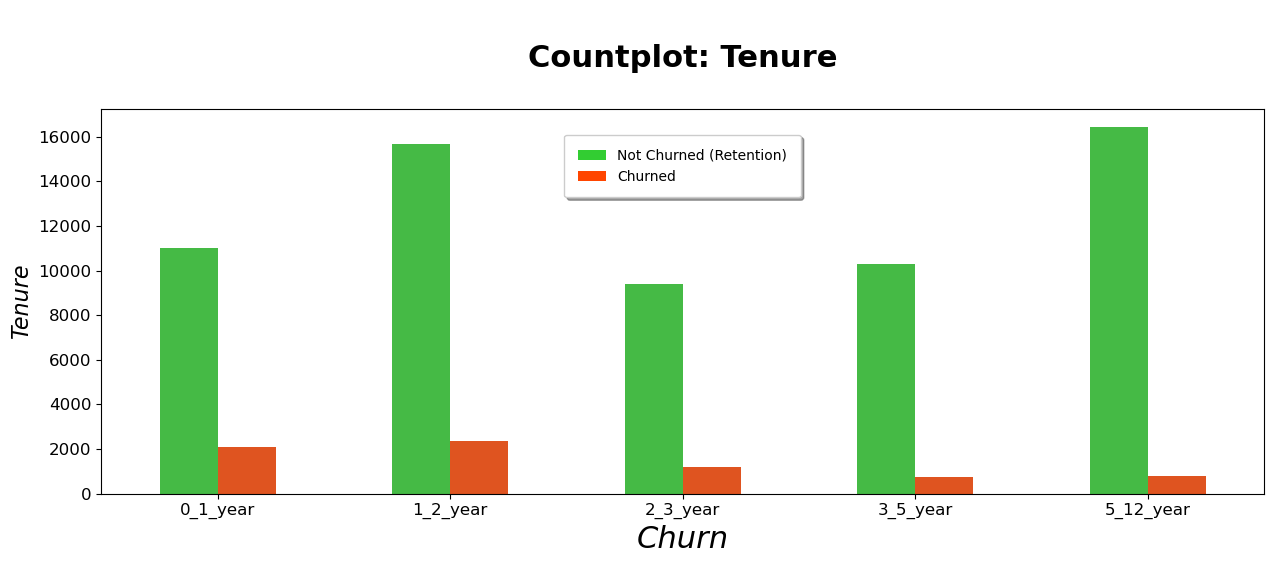

In [47]:
##Visualizing 'age of network' and 'churn'
plt.figure(figsize=(15,5))
tenure_df= data[['tenure','churn_probability']]
colors = {"Not Churned": "#32CD32", "Churned": "#FF4500"}
sns.countplot(x = 'tenure', hue = 'churn_probability',data = tenure_df,palette=['#32CD32', '#FF4500'], width=0.5)

plt.title(f"\nCountplot: Tenure\n", fontsize=22, fontweight='bold')
plt.ylabel("Tenure", fontsize=16, fontstyle='italic')
plt.xlabel("Churn", fontsize=22, fontstyle='italic')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Create custom legend elements
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=colors["Not Churned"], label='Not Churned (Retention)'),
    Patch(facecolor=colors["Churned"], label='Churned')
]
plt.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(0.5, 0.95), fontsize=10,
          frameon=True, framealpha=1, shadow=True, borderpad=1, facecolor='white')
plt.show()

#### Observations

Tenure and Churn: The chart illustrates a strong relationship between customer tenure and the probability of churn. As tenure increases, the number of customers who churn decreases significantly.

Early Churn: The highest proportion of churn occurs in the "0_1_year" category, indicating a significant number of customers churn within their first year of service.

Reduced Churn with Tenure: The proportion of churn decreases steadily as tenure increases, with the lowest churn rates observed in the "5_12_year" category. This suggests that customer loyalty increases over time.

Possible Interpretations

Customer Loyalty: The decreasing churn rate with increasing tenure could be attributed to customer loyalty building over time. Longer-tenure customers might be more satisfied with the service and less likely to switch providers.
Early Churn Drivers: Understanding the reasons behind early churn is crucial. Factors like initial service dissatisfaction, unmet expectations, or lack of engagement could be contributing to the high churn rate in the first year.
Retention Strategies: Targeted retention strategies could be implemented to address the high churn rate in the early stages. This might involve proactive outreach, personalized offers, or improved onboarding experiences.

In [49]:
##Since this is not a time-series based analysis, we might also eliminate date columns as they won't be useful for our analysis
date_columns_list= list(data.columns[data.columns.str.contains('date')])
print("Columns containing Dates:", date_columns_list)
##Dropping the date columns
data.drop(date_columns_list, axis=1, inplace=True)
data.head()

Columns containing Dates: ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8']


,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,fb_user_8,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,tot_rech_data_amt_6,tot_rech_data_amt_7,tot_rech_data_amt_8,av_rech_data_amt_6_7,tenure
0,0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,...,NaN,0.0,0.0,0.0,0,0.0,0.0,0.0,71.0,5_12_year
1,1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,...,NaN,0.0,0.0,0.0,0,0.0,145.0,0.0,145.0,1_2_year
2,2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,...,NaN,0.0,0.0,0.0,0,0.0,0.0,0.0,95.0,2_3_year
3,3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,...,NaN,0.0,0.0,0.0,0,0.0,0.0,0.0,200.0,2_3_year
4,4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,...,1.0,0.0,0.0,0.0,0,1225.0,1337.0,852.0,1494.0,1_2_year


In [50]:
##Let's check for a record (i.e. index 21: example)
print("---------------------------------------------------------------------------------------")
print("'loc_og_mou_6' = 'loc_og_t2t_mou_6' + 'loc_og_t2m_mou_6' + 'loc_og_t2f_mou_6'")
print(data.loc[21,'loc_og_mou_6'],"==",data.loc[21,['loc_og_t2t_mou_6','loc_og_t2m_mou_6','loc_og_t2f_mou_6']].sum())
print("---------------------------------------------------------------------------------------")
print("'std_og_mou_6' = 'std_og_t2t_mou_6' + 'std_og_t2m_mou_6' + 'std_og_t2f_mou_6'")
print(data.loc[21,'std_og_mou_6'],"==",data.loc[21,['std_og_t2t_mou_6','std_og_t2m_mou_6','std_og_t2f_mou_6']].sum())
print("---------------------------------------------------------------------------------------")
print("'total_og_mou_6' = 'loc_og_mou_6' + 'std_og_mou_6' +  'spl_og_mou_6' + 'isd_og_mou_6'")
print(data.loc[21,'total_og_mou_6'],"==",data.loc[21,['loc_og_mou_6','std_og_mou_6','spl_og_mou_6','isd_og_mou_6']].sum())

---------------------------------------------------------------------------------------
'loc_og_mou_6' = 'loc_og_t2t_mou_6' + 'loc_og_t2m_mou_6' + 'loc_og_t2f_mou_6'
191.74 == 191.74
---------------------------------------------------------------------------------------
'std_og_mou_6' = 'std_og_t2t_mou_6' + 'std_og_t2m_mou_6' + 'std_og_t2f_mou_6'
21.78 == 21.77
---------------------------------------------------------------------------------------
'total_og_mou_6' = 'loc_og_mou_6' + 'std_og_mou_6' +  'spl_og_mou_6' + 'isd_og_mou_6'
213.53 == 213.52


In [51]:
##Check for outgoing(og) mou features (just for 6th month)
og_mou_features = list(data.columns[data.columns.str.contains('.*_og_.*mou_6')])
og_mou_features

['roam_og_mou_6',
 'loc_og_t2t_mou_6',
 'loc_og_t2m_mou_6',
 'loc_og_t2f_mou_6',
 'loc_og_t2c_mou_6',
 'loc_og_mou_6',
 'std_og_t2t_mou_6',
 'std_og_t2m_mou_6',
 'std_og_t2f_mou_6',
 'std_og_mou_6',
 'isd_og_mou_6',
 'spl_og_mou_6',
 'total_og_mou_6']

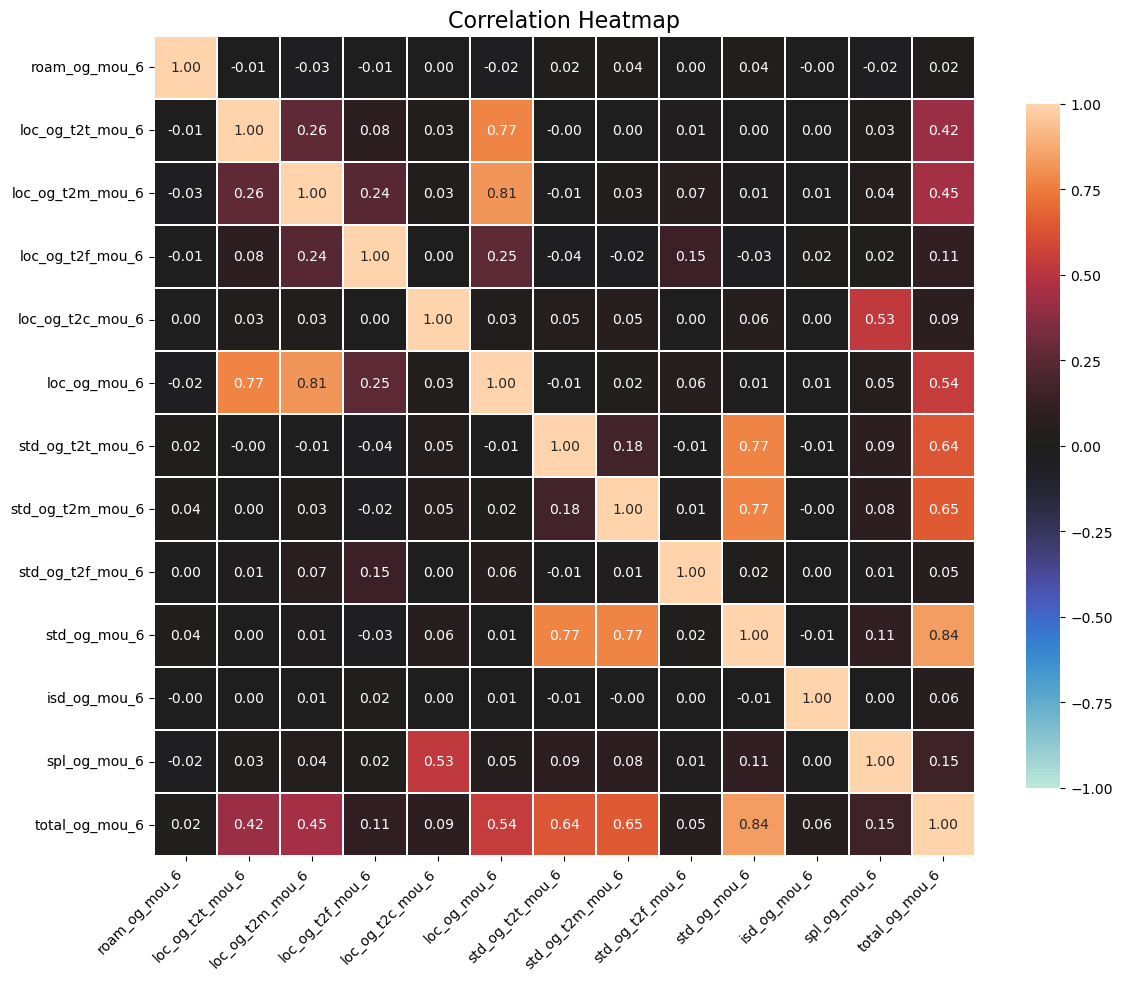

In [52]:
##Let's check the correlation between these variables to see if there is pattern between variables

def plot_correlation_heatmap(data, features, title="Correlation Heatmap"):
    corr = data[features].corr(numeric_only=True)

    # Define a custom color palette
    colors = ["#3498db", "#e74c3c"]
    # cmap = sns.diverging_palette(220, 10, as_cmap=True)

    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(
        corr, cbar_kws={"shrink": 0.8},
        vmin=-1, vmax=1, center=0, square=True,
        annot=True, linewidths=0.1, annot_kws={"size": 10}, fmt=".2f")
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


plot_correlation_heatmap(data, og_mou_features)

In [53]:
##Dropping 'loc_og_mou', 'std_og_mou' and 'total_og_mou' for all 3 months
drop_og_mou_features = list(data.columns[data.columns.str.contains('loc_og_mou_|std_og_mou_|total_og_mou_')])
print('List of features dropped:\n', drop_og_mou_features)

data.drop(drop_og_mou_features, axis=1, inplace= True)

List of features dropped:
 ['loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8']


In [54]:
##Check for incoming(ic) mou features (just for 6th month)
ic_mou_features = list(data.columns[data.columns.str.contains('.*_ic_.*mou_6')])
ic_mou_features

['roam_ic_mou_6',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2f_mou_6',
 'loc_ic_mou_6',
 'std_ic_t2t_mou_6',
 'std_ic_t2m_mou_6',
 'std_ic_t2f_mou_6',
 'std_ic_mou_6',
 'total_ic_mou_6',
 'spl_ic_mou_6',
 'isd_ic_mou_6']

In [55]:
data[ic_mou_features].describe()

,roam_ic_mou_6,loc_ic_t2t_mou_6,loc_ic_t2m_mou_6,loc_ic_t2f_mou_6,loc_ic_mou_6,std_ic_t2t_mou_6,std_ic_t2m_mou_6,std_ic_t2f_mou_6,std_ic_mou_6,total_ic_mou_6,spl_ic_mou_6,isd_ic_mou_6
count,67231.000000,67231.000000,67231.000000,67231.000000,67231.000000,67231.000000,67231.000000,67231.000000,67231.000000,69999.000000,67231.000000,67231.000000
mean,9.765435,48.043255,107.152439,12.050672,167.255126,9.476958,20.734858,2.146273,32.360632,199.710640,0.061932,7.394167
std,57.374429,140.499757,168.455999,39.416076,252.576231,51.664472,80.294236,16.522232,104.381082,290.114823,0.164823,60.951165
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.030000,17.390000,0.000000,30.630000,0.000000,0.000000,0.000000,0.000000,38.640000,0.000000,0.000000
50%,0.000000,15.740000,56.460000,0.880000,92.430000,0.000000,2.040000,0.000000,5.910000,114.780000,0.000000,0.000000
75%,0.000000,46.980000,132.020000,8.140000,208.325000,4.060000,14.960000,0.000000,26.780000,251.070000,0.000000,0.000000
max,2850.980000,5315.590000,4450.740000,1872.340000,7454.630000,3336.380000,5647.160000,1351.110000,5712.110000,7716.140000,19.760000,6789.410000


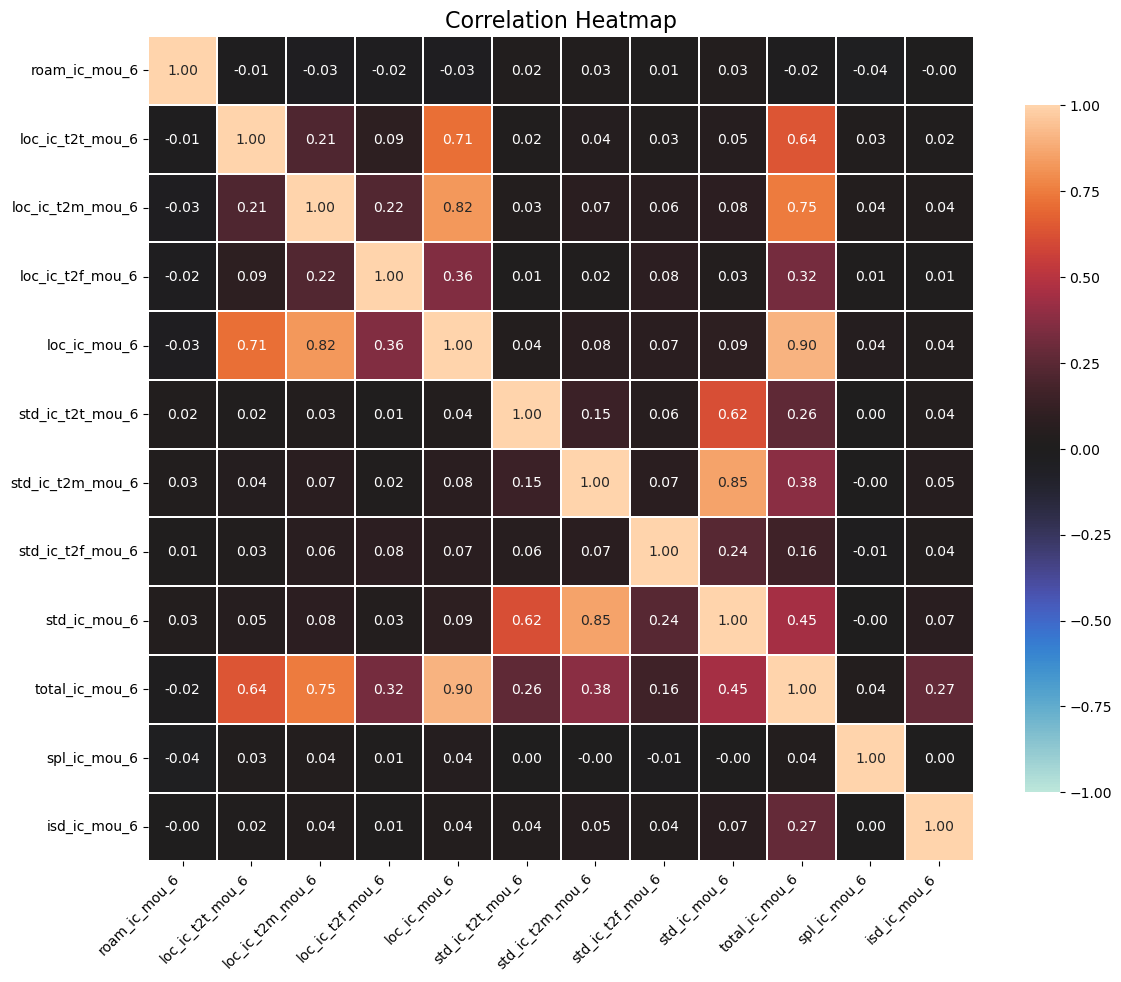

In [56]:
plot_correlation_heatmap(data, ic_mou_features)

In [57]:
##Let's check for a record (i.e. index 10: example)
print("---------------------------------------------------------------------------------------")
print("'loc_ic_mou_6' = 'loc_ic_t2t_mou_6' + 'loc_ic_t2m_mou_6' + 'loc_ic_t2f_mou_6'")
print(data.loc[10,'loc_ic_mou_6'],"==",data.loc[10,['loc_ic_t2t_mou_6','loc_ic_t2m_mou_6','loc_ic_t2f_mou_6']].sum())
print("---------------------------------------------------------------------------------------")
print("'std_ic_mou_6' = 'std_ic_t2t_mou_6' + 'std_ic_t2m_mou_6' + 'std_ic_t2f_mou_6'")
print(data.loc[10,'std_ic_mou_6'],"==",data.loc[10,['std_ic_t2t_mou_6','std_ic_t2m_mou_6','std_ic_t2f_mou_6']].sum())
print("---------------------------------------------------------------------------------------")
print("'total_ic_mou_6' = 'loc_ic_mou_6' + 'std_ic_mou_6' + 'isd_ic_mou_6' + 'spl_ic_mou_6'")
print(data.loc[10,'total_ic_mou_6'],"==",data.loc[10,['loc_ic_mou_6','std_ic_mou_6','isd_ic_mou_6', 'spl_ic_mou_6']].sum())

---------------------------------------------------------------------------------------
'loc_ic_mou_6' = 'loc_ic_t2t_mou_6' + 'loc_ic_t2m_mou_6' + 'loc_ic_t2f_mou_6'
140.69 == 140.68
---------------------------------------------------------------------------------------
'std_ic_mou_6' = 'std_ic_t2t_mou_6' + 'std_ic_t2m_mou_6' + 'std_ic_t2f_mou_6'
444.79 == 444.79
---------------------------------------------------------------------------------------
'total_ic_mou_6' = 'loc_ic_mou_6' + 'std_ic_mou_6' + 'isd_ic_mou_6' + 'spl_ic_mou_6'
585.49 == 585.48


In [58]:
##Dropping 'loc_ic_mou', 'std_ic_mou' and 'total_ic_mou' for all 3 months
drop_ic_mou_features = list(data.columns[data.columns.str.contains('loc_ic_mou_|std_ic_mou_|total_ic_mou_')])
print('List of features dropped:\n', drop_ic_mou_features)

data.drop(drop_ic_mou_features, axis=1, inplace= True)

List of features dropped:
 ['loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8']


In [59]:
##Check for missing values in data dataframe (show only missing value columns)
missing_val_cols_prcnt = round(100*data.isnull().sum()/len(data.index),2)
missing = pd.DataFrame(missing_val_cols_prcnt[missing_val_cols_prcnt!=0].sort_values(ascending=False))  #Descending order(% NaN)
missing.reset_index(inplace=True)
missing= missing.rename(columns={'index':'features',0:'Null_Percentage'})
missing

,features,Null_Percentage
0,night_pck_user_6,74.90
1,fb_user_6,74.90
2,night_pck_user_7,74.48
3,fb_user_7,74.48
4,night_pck_user_8,73.69
...,...,...
70,std_og_t2f_mou_7,3.84
71,loc_ic_t2m_mou_7,3.84
72,isd_og_mou_7,3.84
73,loc_ic_t2t_mou_7,3.84


**Observation:** <br>(i) Since we checked at the very beginning that `'fb_user_*''` and `'night_pck_user_*'` attributes had same number of missing values as the dates of recharging data plan. Thus, the number of missing values, imply no recharge done. However, 0 has a meaning here, we just can't impute with 0. Also, a lot of values are missing (46.8%) and these features don't seem to be significant. Hence, dropping the `'fb_user_*''` and `'night_pck_user_*'` attributes

In [61]:
##Dropping 'fb_user_*' and 'night_pck_user_*' features
cols_to_drop = ['fb_user_6', 'fb_user_7', 'fb_user_8', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8']
data.drop(cols_to_drop, axis=1, inplace= True)

In [62]:
##Imputing 'ic_others' and 'og_others' with 0 (<=3.91% missing values)
cols_to_impute = data.columns[data.columns.str.contains('ic_others|og_others|_7|_6|_8')]
data[cols_to_impute] = data[cols_to_impute].replace(np.nan, 0)

In [63]:
null_prcnt_df(data)

,Null_Percentage
id,0.000000
std_ic_t2f_mou_6,0.000000
max_rech_data_7,0.000000
max_rech_data_6,0.000000
total_rech_data_8,0.000000
total_rech_data_7,0.000000
total_rech_data_6,0.000000
last_day_rch_amt_8,0.000000
last_day_rch_amt_7,0.000000
last_day_rch_amt_6,0.000000


In [64]:
##Features in data corresponding to 'month_6'
attributes_6 = list(data.columns[data.columns.str.contains("_6")])
print(attributes_6)
print("Total no of attribues for the month of June: ",len(attributes_6))
print("---------------------------------------------------------------------")
##Features in data corresponding to 'month_7'
attributes_7 = list(data.columns[data.columns.str.contains("_7")])
print(attributes_7)
print("Total no of attribues for the month of June: ",len(attributes_7))
print("---------------------------------------------------------------------")

['arpu_6', 'onnet_mou_6', 'offnet_mou_6', 'roam_ic_mou_6', 'roam_og_mou_6', 'loc_og_t2t_mou_6', 'loc_og_t2m_mou_6', 'loc_og_t2f_mou_6', 'loc_og_t2c_mou_6', 'std_og_t2t_mou_6', 'std_og_t2m_mou_6', 'std_og_t2f_mou_6', 'isd_og_mou_6', 'spl_og_mou_6', 'og_others_6', 'loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6', 'loc_ic_t2f_mou_6', 'std_ic_t2t_mou_6', 'std_ic_t2m_mou_6', 'std_ic_t2f_mou_6', 'spl_ic_mou_6', 'isd_ic_mou_6', 'ic_others_6', 'total_rech_num_6', 'total_rech_amt_6', 'max_rech_amt_6', 'last_day_rch_amt_6', 'total_rech_data_6', 'max_rech_data_6', 'av_rech_amt_data_6', 'vol_2g_mb_6', 'vol_3g_mb_6', 'monthly_2g_6', 'sachet_2g_6', 'monthly_3g_6', 'sachet_3g_6', 'tot_rech_data_amt_6', 'av_rech_data_amt_6_7']
Total no of attribues for the month of June:  39
---------------------------------------------------------------------
['arpu_7', 'onnet_mou_7', 'offnet_mou_7', 'roam_ic_mou_7', 'roam_og_mou_7', 'loc_og_t2t_mou_7', 'loc_og_t2m_mou_7', 'loc_og_t2f_mou_7', 'loc_og_t2c_mou_7', 'std_og_t2t_mo

In [65]:
##Firstly, let's drop 'avg_total_rech_plus_data_amt_6_7'
data.drop('av_rech_data_amt_6_7', axis=1, inplace= True)

##Let's combine and take average of remaining '_6'  and '_7' attributes
feature_names_6 = [i.split('_6')[0] for i in attributes_6 if i.endswith("_6")]
feature_names_7 = [i.split('_7')[0] for i in attributes_7 if i.endswith("_7")]

In [66]:
uncommon_feature_names = [i for i,j in (zip(feature_names_6, feature_names_7)) if i!=j]
print(uncommon_feature_names)
print("-------------------------------------------------------------------------")
common_feature_names= [i for i,j in (zip(feature_names_6, feature_names_7)) if i==j]
print(common_feature_names)

[]
-------------------------------------------------------------------------
['arpu', 'onnet_mou', 'offnet_mou', 'roam_ic_mou', 'roam_og_mou', 'loc_og_t2t_mou', 'loc_og_t2m_mou', 'loc_og_t2f_mou', 'loc_og_t2c_mou', 'std_og_t2t_mou', 'std_og_t2m_mou', 'std_og_t2f_mou', 'isd_og_mou', 'spl_og_mou', 'og_others', 'loc_ic_t2t_mou', 'loc_ic_t2m_mou', 'loc_ic_t2f_mou', 'std_ic_t2t_mou', 'std_ic_t2m_mou', 'std_ic_t2f_mou', 'spl_ic_mou', 'isd_ic_mou', 'ic_others', 'total_rech_num', 'total_rech_amt', 'max_rech_amt', 'last_day_rch_amt', 'total_rech_data', 'max_rech_data', 'av_rech_amt_data', 'vol_2g_mb', 'vol_3g_mb', 'monthly_2g', 'sachet_2g', 'monthly_3g', 'sachet_3g', 'tot_rech_data_amt']


In [67]:
#Since all features of '_6' exist in '_7'. Therefore let's find the new 'avg_6_7' features
##(together representing the good phase)
f6_cols, f7_cols=[], []
for feature in common_feature_names:
    f6= feature+'_6'
    f7= feature+'_7'
    avg_67= feature+'_avg_6_7'

    f6_cols.append(f6)  ##Storing all remaining attributes from '_6'
    f7_cols.append(f7)  ##Storing all remaining attributes from '_7'

    data[avg_67] = (data[f6] + data[f7])/2

data.head()

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,total_rech_data_avg_6_7,max_rech_data_avg_6_7,av_rech_amt_data_avg_6_7,vol_2g_mb_avg_6_7,vol_3g_mb_avg_6_7,monthly_2g_avg_6_7,sachet_2g_avg_6_7,monthly_3g_avg_6_7,sachet_3g_avg_6_7,tot_rech_data_amt_avg_6_7
0,0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,...,0.0,0.0,0.0,0.000,0.00,0.0,0.0,0.0,0.0,0.0
1,1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,...,0.5,72.5,72.5,176.455,1.98,0.0,0.0,0.5,0.0,72.5
2,2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,...,0.0,0.0,0.0,0.000,0.00,0.0,0.0,0.0,0.0,0.0
3,3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,...,0.0,0.0,0.0,0.000,0.00,0.0,0.0,0.0,0.0,0.0
4,4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,...,7.0,33.0,183.0,349.845,0.00,0.0,6.5,0.0,0.5,1281.0


In [68]:
##Dropping the fundamental explanatory variables belonging to '_6'
data.drop(f6_cols, axis=1, inplace=True)
##Dropping the fundamental explanatory variables belonging to '_7'
data.drop(f7_cols, axis=1, inplace=True)
data.head()

,id,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,...,total_rech_data_avg_6_7,max_rech_data_avg_6_7,av_rech_amt_data_avg_6_7,vol_2g_mb_avg_6_7,vol_3g_mb_avg_6_7,monthly_2g_avg_6_7,sachet_2g_avg_6_7,monthly_3g_avg_6_7,sachet_3g_avg_6_7,tot_rech_data_amt_avg_6_7
0,0,7.527,1.29,2.33,0.0,0.00,0.28,2.33,0.00,0.00,...,0.0,0.0,0.0,0.000,0.00,0.0,0.0,0.0,0.0,0.0
1,1,42.953,0.00,30.89,0.0,0.00,0.00,0.00,0.00,29.79,...,0.5,72.5,72.5,176.455,1.98,0.0,0.0,0.5,0.0,72.5
2,2,0.000,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.000,0.00,0.0,0.0,0.0,0.0,0.0
3,3,111.095,0.00,50.23,0.0,1.63,0.00,23.63,0.00,8.03,...,0.0,0.0,0.0,0.000,0.00,0.0,0.0,0.0,0.0,0.0
4,4,101.565,6.13,9.63,0.0,0.00,6.13,4.61,5.01,0.00,...,7.0,33.0,183.0,349.845,0.00,0.0,6.5,0.0,0.5,1281.0


In [69]:
data.shape

(69999, 82)

In [70]:
data.describe(percentiles= [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999])

,id,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,...,total_rech_data_avg_6_7,max_rech_data_avg_6_7,av_rech_amt_data_avg_6_7,vol_2g_mb_avg_6_7,vol_3g_mb_avg_6_7,monthly_2g_avg_6_7,sachet_2g_avg_6_7,monthly_3g_avg_6_7,sachet_3g_avg_6_7,tot_rech_data_amt_avg_6_7
count,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,...,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000
mean,34999.000000,278.858826,125.943607,186.146273,6.634328,9.254848,43.269280,86.301054,3.467948,1.345676,...,0.651645,32.004207,49.905478,51.507064,125.553163,0.081344,0.415135,0.076773,0.078394,160.502018
std,20207.115084,351.924315,304.990552,318.453812,51.999899,62.923987,149.944829,150.286404,12.686917,6.374743,...,1.712555,70.692847,118.467768,191.607771,510.101188,0.262188,1.453375,0.332623,0.548096,703.817207
min,0.000000,-945.808000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10%,6999.800000,18.210600,0.000000,0.280000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17499.500000,84.095000,4.110000,23.780000,0.000000,0.000000,0.760000,6.440000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,34999.000000,192.234000,27.840000,83.010000,0.000000,0.000000,10.060000,35.940000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,52498.500000,369.909000,106.280000,216.410000,0.000000,0.000000,37.260000,103.110000,1.760000,0.000000,...,0.500000,23.000000,49.000000,2.927500,0.000000,0.000000,0.000000,0.000000,0.000000,74.500000
90%,62998.200000,614.994600,326.298000,467.636000,4.280000,7.552000,97.230000,223.132000,8.730000,3.110000,...,2.000000,137.500000,175.000000,124.875000,367.480000,0.500000,1.000000,0.000000,0.000000,378.500000
95%,66498.100000,828.464700,596.125000,715.915000,21.992000,38.842000,167.636000,337.531000,17.341000,7.490000,...,3.500000,176.000000,252.000000,315.926500,805.926000,0.500000,2.500000,0.500000,0.500000,756.500000


In [71]:
##Continuous features
cont_cols_hv= [i for i in data.columns if i not in ['churn_probability', 'tenure']]
cont_cols_hv

##Using numpy clip() to cap the values of outliers in between 1 and 99.9 percentiles
import numpy as np
for col in cont_cols_hv:
    percentiles = data[col].quantile([0.01,0.999]).values
    data[col] = np.clip(data[col], percentiles[0], percentiles[1])

In [72]:
##Checking categorical column 'tenure'
data.tenure.head()

0    5_12_year
1     1_2_year
2     2_3_year
3     2_3_year
4     1_2_year
Name: tenure, dtype: category
Categories (5, object): ['0_1_year' < '1_2_year' < '2_3_year' < '3_5_year' < '5_12_year']

In [73]:
#'tenure' is a categorical variable. Converting it into numeric using get_dummies
###Creating dummies for categorical variable 'tenure'
cat_cols= ['tenure']
d_tenure = pd.get_dummies(data['tenure'], prefix='tenure', drop_first = True)
data = pd.concat([data, d_tenure], axis = 1)

##Dropping the 'tenure' column
data.drop(cat_cols, axis=1, inplace=True)

In [74]:
print("\n(churn=1, else 0)")
print("==============================================")
print("Tagging churners [No. of Records]:")
print(data['churn_probability'].value_counts())
print("\nTagging churners (% of total):")
print(round(100*data['churn_probability'].value_counts()/len(data.index),3))
print("==============================================")


(churn=1, else 0)
Tagging churners [No. of Records]:
churn_probability
0    62867
1     7132
Name: count, dtype: int64

Tagging churners (% of total):
churn_probability
0    89.811
1    10.189
Name: count, dtype: float64


In [75]:
data_copy = data.copy()

In [76]:
y = data_copy.pop("churn_probability")
X = data_copy

print("========================================================================")
print("X Dataset: ", X.shape)
print("y Dataset: ", y.shape)
print("========================================================================")

X Dataset:  (69999, 84)
y Dataset:  (69999,)


In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("========================================================================")
print("X Train Dataset: ", X_train.shape)
print("X Test Dataset: ", X_test.shape)
print("y Train Dataset: ", y_train.shape)
print("y Test Dataset: ", y_test.shape)
print("========================================================================")

X Train Dataset:  (55999, 84)
X Test Dataset:  (14000, 84)
y Train Dataset:  (55999,)
y Test Dataset:  (14000,)


In [78]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

smote = SMOTE(random_state = 42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 5710
Before OverSampling, counts of label '0': 50289 

After OverSampling, the shape of train_X: (100578, 84)
After OverSampling, the shape of train_y: (100578,) 

After OverSampling, counts of label '1': 50289
After OverSampling, counts of label '0': 50289


In [79]:
X_train = X_train_res
y_train = y_train_res

In [80]:
##Creating a function to find binary value columns from the 'telecom_hv' dataframe (if any)
def binary_val_cols(df):
    df_1 = df.copy()
    dualsvcol = (df_1.nunique()==2)
    list_dualsvcol = list(dualsvcol[dualsvcol.values==True].index)
    return list_dualsvcol

binary_cols = binary_val_cols(df= X_train)
print(binary_cols)

['tenure_1_2_year', 'tenure_2_3_year', 'tenure_3_5_year', 'tenure_5_12_year']


In [81]:
##Dataframe with binary columns
df_binary_train = X_train.loc[:, binary_cols]
df_binary_test = X_test.loc[:, binary_cols]

##Dropping binary dummy variables and we shall concat them later to preserve the scale
df_train = X_train.drop(binary_cols, axis=1)
df_test = X_test.drop(binary_cols, axis=1)

##StandardScaler
all_cols = df_train.columns
scaler = StandardScaler()

#scaler fit_transform on train data
df_train[all_cols] = scaler.fit_transform(df_train[all_cols])
#concat dummies:Train set
X_train_scaled = pd.concat([df_train, df_binary_train], axis=1)

#scaler transform on test data
df_test[all_cols] = scaler.transform(df_test[all_cols])
#concat dummies: Test set
X_test_scaled = pd.concat([df_test, df_binary_test], axis=1)

In [82]:
# # Standardize the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# Logistic Regression with RFE
log_reg = LogisticRegression(random_state=42)
rfe = RFE(log_reg, n_features_to_select=15)
X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)
X_test_rfe = rfe.transform(X_test_scaled)

log_reg.fit(X_train_rfe, y_train)
y_pred_rfe = log_reg.predict(X_test_rfe)

print("Logistic Regression with RFE")
other_metrics_logistic_model(confusion_matrix(y_test, y_pred_rfe))

Logistic Regression with RFE


,Value
Evaluation Metrics,
Accuracy,0.8081
Sensitivity/Recall,0.7876
Specificity,0.8105
False Positive Rate,0.1895
Positive Predictive Value/Precision,0.3196
Negative Predictive Value,0.9712
Misclassification Rate,0.1919


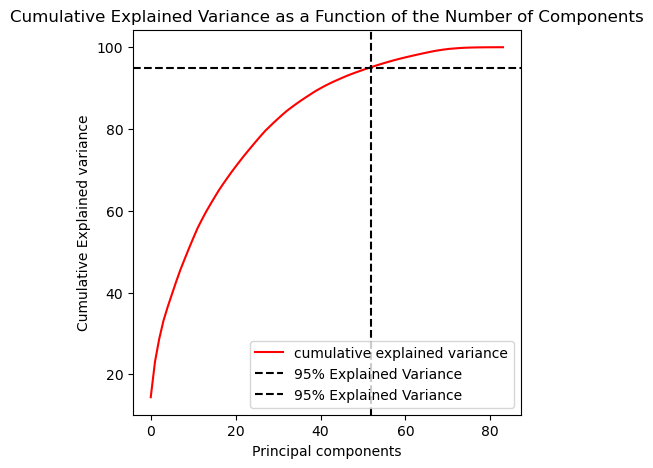

In [83]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
cumsum = np.cumsum(pca.explained_variance_ratio_)*100
d = [n for n in range(len(cumsum))]
plt.figure(figsize=(5,5))
plt.plot(d,cumsum, color = 'red',label='cumulative explained variance')
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axhline(y = 95, color='k', linestyle='--', label = '95% Explained Variance')
plt.axvline(x = 52, color='k', linestyle='--', label = '95% Explained Variance')
plt.legend(loc='best')

In [84]:
# Logistic Regression with PCA
pca = PCA(0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

log_reg.fit(X_train_pca, y_train)
y_pred_pca = log_reg.predict(X_test_pca)

In [99]:
y_train_pred = log_reg.predict(X_train_pca)
print("\nLogistic Regression with PCA (Trained Metrics)")
other_metrics_logistic_model(confusion_matrix(y_train, y_train_pred))


Logistic Regression with PCA (Trained Metrics)


,Value
Evaluation Metrics,
Accuracy,0.8356
Sensitivity/Recall,0.8784
Specificity,0.7929
False Positive Rate,0.2071
Positive Predictive Value/Precision,0.8092
Negative Predictive Value,0.8670
Misclassification Rate,0.1644


In [103]:
print("\nLogistic Regression with PCA (Test Metrics)")
other_metrics_logistic_model(confusion_matrix(y_test, y_pred_pca))


Logistic Regression with PCA (Test Metrics)


,Value
Evaluation Metrics,
Accuracy,0.8016
Sensitivity/Recall,0.8615
Specificity,0.7948
False Positive Rate,0.2052
Positive Predictive Value/Precision,0.3219
Negative Predictive Value,0.9807
Misclassification Rate,0.1984


In [86]:
# Logistic Regression with PCA and Hyperparameter Tuning
param_grid = {
    'C': [0.01, 0.1, 1, 1.25, 5, 10, 100],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_pca, y_train)

best_log_reg = grid_search.best_estimator_

## best_log_reg = LogisticRegression(C=0.01, random_state=42, solver='saga')
y_pred_pca_tuned = best_log_reg.predict(X_test_pca)


In [109]:
y_train_pred_pca_tuned = best_log_reg.predict(X_train_pca)
print("\nLogistic Regression with PCA and Hyperparameter Tuning (Train Metrics)")
other_metrics_logistic_model(confusion_matrix(y_train, y_train_pred_pca_tuned))


Logistic Regression with PCA and Hyperparameter Tuning (Train Metrics)


,Value
Evaluation Metrics,
Accuracy,0.8356
Sensitivity/Recall,0.8784
Specificity,0.7929
False Positive Rate,0.2071
Positive Predictive Value/Precision,0.8092
Negative Predictive Value,0.8670
Misclassification Rate,0.1644


In [105]:
print("\nLogistic Regression with PCA and Hyperparameter Tuning (Test Metrics)")
other_metrics_logistic_model(confusion_matrix(y_test, y_pred_pca_tuned))


Logistic Regression with PCA and Hyperparameter Tuning (Test Metrics)


,Value
Evaluation Metrics,
Accuracy,0.8014
Sensitivity/Recall,0.8608
Specificity,0.7947
False Positive Rate,0.2053
Positive Predictive Value/Precision,0.3216
Negative Predictive Value,0.9806
Misclassification Rate,0.1986


In [88]:
# Random Forest Model with PCA and Hyperparameter Tuning
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(0.95)),
    ('rf', RandomForestClassifier(random_state=42))
])

rf_param_grid = {
    'rf__max_features': [7],
    'rf__max_depth': [24,25],
    'rf__min_samples_leaf': [100, 200, 300],
    'rf__n_estimators': [20, 50, 75],
    'rf__min_samples_split': [250,350,450],
    'rf__max_leaf_nodes': [25,27]
}

rf_grid_search = RandomizedSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring='accuracy', n_iter=50)
rf_grid_search.fit(X_train_pca, y_train_res)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('pca', PCA(n_components=0.95)),
                                             ('rf',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=50,
                   param_distributions={'rf__max_depth': [24, 25],
                                        'rf__max_features': [7],
                                        'rf__max_leaf_nodes': [25, 27],
                                        'rf__min_samples_leaf': [100, 200, 300],
                                        'rf__min_samples_split': [250, 350,
                                                                  450],
                                        'rf__n_estimators': [20, 50, 75]},
                   scoring='accuracy')

In [115]:
# Evaluate Models
rf_best_model = rf_grid_search.best_estimator_

rf_y_pred = rf_best_model.predict(X_test_pca)
rf_y_train_pred = rf_best_model.predict(X_train_pca)

print("\n Random Forest Model (Train Metrics)")
other_metrics_logistic_model(confusion_matrix(y_train, rf_y_train_pred))




 Random Forest Model (Train Metrics)


,Value
Evaluation Metrics,
Accuracy,0.8066
Sensitivity/Recall,0.7557
Specificity,0.8575
False Positive Rate,0.1425
Positive Predictive Value/Precision,0.8413
Negative Predictive Value,0.7783
Misclassification Rate,0.1934


In [117]:
print("\n Random Forest Model (Test Metrics)")
other_metrics_logistic_model(confusion_matrix(y_test, rf_y_pred))


 Random Forest Model (Test Metrics)


,Value
Evaluation Metrics,
Accuracy,0.8364
Sensitivity/Recall,0.6681
Specificity,0.8554
False Positive Rate,0.1446
Positive Predictive Value/Precision,0.3431
Negative Predictive Value,0.9580
Misclassification Rate,0.1636


In [91]:
# XGBoost Model with PCA and Hyperparameter Tuning
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(0.95)),
    ('xgb', XGBClassifier(random_state=42))
])

xgb_param_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 6],
    'xgb__learning_rate': [0.01, 0.1]
}

xgb_grid_search = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=5, scoring='accuracy')
xgb_grid_search.fit(X_train_res, y_train_res)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=0.95)),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow...
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             param_grid={'xgb__learning_rate': [0.01, 0.1],
                         'xgb__max_depth': [3, 6],
                         'xgb__n_estimators': [100, 200]},
             scoring='accuracy')

In [121]:
xgb_best_model = xgb_grid_search.best_estimator_

xgb_y_pred = xgb_best_model.predict(X_test)
xgb_y_train_pred = xgb_best_model.predict(X_train)

print("\nXGBoost Model(Train Metrics)")
other_metrics_logistic_model(confusion_matrix(y_train, xgb_y_train_pred))


XGBoost Model(Train Metrics)


,Value
Evaluation Metrics,
Accuracy,0.9412
Sensitivity/Recall,0.9523
Specificity,0.9300
False Positive Rate,0.0700
Positive Predictive Value/Precision,0.9315
Negative Predictive Value,0.9512
Misclassification Rate,0.0588


In [119]:
print("\nXGBoost Model(Test Metrics)")
other_metrics_logistic_model(confusion_matrix(y_test, xgb_y_pred))


XGBoost Model(Test Metrics)


,Value
Evaluation Metrics,
Accuracy,0.8933
Sensitivity/Recall,0.7504
Specificity,0.9094
False Positive Rate,0.0906
Positive Predictive Value/Precision,0.4837
Negative Predictive Value,0.9699
Misclassification Rate,0.1067


In [127]:
sample.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


In [129]:
unseen.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00


In [133]:
# submission_data = unseen.set_index('id')[]
# submission_data.shape

KeyError: "['id', 'tot_rech_data_amt_8', 'arpu_avg_6_7', 'onnet_mou_avg_6_7', 'offnet_mou_avg_6_7', 'roam_ic_mou_avg_6_7', 'roam_og_mou_avg_6_7', 'loc_og_t2t_mou_avg_6_7', 'loc_og_t2m_mou_avg_6_7', 'loc_og_t2f_mou_avg_6_7', 'loc_og_t2c_mou_avg_6_7', 'std_og_t2t_mou_avg_6_7', 'std_og_t2m_mou_avg_6_7', 'std_og_t2f_mou_avg_6_7', 'isd_og_mou_avg_6_7', 'spl_og_mou_avg_6_7', 'og_others_avg_6_7', 'loc_ic_t2t_mou_avg_6_7', 'loc_ic_t2m_mou_avg_6_7', 'loc_ic_t2f_mou_avg_6_7', 'std_ic_t2t_mou_avg_6_7', 'std_ic_t2m_mou_avg_6_7', 'std_ic_t2f_mou_avg_6_7', 'spl_ic_mou_avg_6_7', 'isd_ic_mou_avg_6_7', 'ic_others_avg_6_7', 'total_rech_num_avg_6_7', 'total_rech_amt_avg_6_7', 'max_rech_amt_avg_6_7', 'last_day_rch_amt_avg_6_7', 'total_rech_data_avg_6_7', 'max_rech_data_avg_6_7', 'av_rech_amt_data_avg_6_7', 'vol_2g_mb_avg_6_7', 'vol_3g_mb_avg_6_7', 'monthly_2g_avg_6_7', 'sachet_2g_avg_6_7', 'monthly_3g_avg_6_7', 'sachet_3g_avg_6_7', 'tot_rech_data_amt_avg_6_7'] not in index"